## Seq2Seq Transformer with PyTorch

* Task: Paraphrase Generation (data = MSCOCO).
* Type: Vaswani et al. (2017)
* Modified based on: http://nlp.seas.harvard.edu/2018/04/03/attention.html
* Features: full pipeline comments on the original code with modification (you have all tensor manip information available, most crucially shape morphing).
* PyTorch version: 0.3.1

**NB:** to train an actual functioning model takes way more epochs, this is posted for demo purpose.

In [2]:
import os
import copy
import math
import time
import dill
import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from nltk.translate.bleu_score import sentence_bleu as bleu
from nltk.translate.bleu_score import SmoothingFunction

from utils import *
from seq2seq_data_loader import *

SMOOTH = SmoothingFunction()

### DATA PREP

In [3]:
loader = Seq2SeqDataLoaderTransformer('mscoco/')
indexer, train_pairs, train_lens, test_pairs, test_lens = loader.load()

... loading training data.
... loading test data.
Done!



In [64]:
%%time

glove_path = "glove_embeddings/glove.6B.300d.txt"
embeddings = np.zeros((indexer.size,300)) 
word2embedding = {}
count = 0
print "Reading embeddings ...\n"
with open(glove_path, 'r') as f:
    for line in f:
        count += 1
        line = line.split()
        word = line[0]
        embedding = np.array(line[1:], dtype=float)
        word2embedding[word] = embedding
        if count%10000==0:
            print '... processed %d lines.' % count
print "\nLoading embeddings to matrix ..."
oov_size = 0
for i in range(1,indexer.size): # 0 saved for padding later. 
    word = indexer.get_word(i)
    if word in word2embedding:
        embeddings[i] = word2embedding[word]
    else:
        embeddings[i] = np.zeros(300)
        oov_size += 1
print "Done (#oov = %d)" % oov_size
del word2embedding

Reading embeddings ...

... processed 10000 lines.
... processed 20000 lines.
... processed 30000 lines.
... processed 40000 lines.
... processed 50000 lines.
... processed 60000 lines.
... processed 70000 lines.
... processed 80000 lines.
... processed 90000 lines.
... processed 100000 lines.
... processed 110000 lines.
... processed 120000 lines.
... processed 130000 lines.
... processed 140000 lines.
... processed 150000 lines.
... processed 160000 lines.
... processed 170000 lines.
... processed 180000 lines.
... processed 190000 lines.
... processed 200000 lines.
... processed 210000 lines.
... processed 220000 lines.
... processed 230000 lines.
... processed 240000 lines.
... processed 250000 lines.
... processed 260000 lines.
... processed 270000 lines.
... processed 280000 lines.
... processed 290000 lines.
... processed 300000 lines.
... processed 310000 lines.
... processed 320000 lines.
... processed 330000 lines.
... processed 340000 lines.
... processed 350000 lines.
... p

### MODEL

In [4]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        """
        Args:
            encoder: Encoder()
            decoder: Decoder()
            src_embed: Sequential(Embedding(), PositionalEncoding())
            tgt_embed: Sequential(Embedding(), PositionalEncoding())
            generator: Generator(), final linear-softmax layer
        """
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        """Take in and process masked src and target sequences.
        
        Args:
            src: Variable(torch.LongTensor()), <bc,mt-enc>
            tgt: Variable(torch.LongTensor()), <bc,mt-dec>
            src_mask: Variable(torch.LongTensor()), <bc,1,mt-enc>
            tgt_mask: Variable(torch.LongTensor()), <bc,1,mt-dec>
        Returns:fu
            <bc,mt-dec,d_model>
        """
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)

    def encode(self, src, src_mask):
        """
        Args:
            src: Variable(torch.LongTensor()), <bc,mt-enc>
            src_mask: Variable(torch.LongTensor()), <bc,1,mt-enc>
        Returns:
            <bc,mt-dec,d_model>
        """
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        """
        Args:
            memory: Variable(torch.LongTensor()), <bc,mt-enc,d_model>
            src_mask: Variable(torch.LongTensor()), <bc,1,mt-enc>
            tgt: Variable(torch.LongTensor()), <bc,mt-dec>
            tgt_mask: Variable(torch.LongTensor()), <bc,1,mt-dec>
        Returns:
            <bc,mt-dec,d_model>
        """
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    
    def __init__(self, d_model, vocab):
        """
        Args:
            d_model: (main) hidden size of the model.
            vocab: vocab size (of the decoder).
        """
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        """
        Args:
            x: <bc,mt-dec,d_model>
        Returns:
            <bc,mt-dec,vocab>
        """
        return F.log_softmax(self.proj(x), dim=-1)

def clones(module, N):
    """Produce N identical layers.
    
    Args:
        module: any nn.Module object.
        N: number of copies.
    Returns:
        a nn.ModuleList with N copies of module.
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Encoder(nn.Module):
    """Core encoder is a stack of N layers"""
    
    def __init__(self, layer, N):
        """
        Args:
            layer: EncoderLayer()
            N: number of layers.
        """
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        """Pass the input (and mask) through each layer in turn.
        
        Args:
            x: <bc,mt-enc,d_model>
            mask: <bt,1,m-enc>
        Returns:
            <bc,mt-enc,d_model>
        """
        for layer in self.layers:
            x = layer(x, mask)
                # shape does not change.
            
        return self.norm(x)

class LayerNorm(nn.Module):
    """Construct a layernorm module (See citation for details)."""
    
    def __init__(self, features, eps=1e-6):
        """
        Args:
            features: (main) hidden size (i.e. d_model).
            eps: perturbation size.
        """
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        """
        Args:
            x: <bc,mt-enc,d_model>
        Returns:
            <bc,mt-enc,d_model> standardized.
        """
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    
    def __init__(self, size, dropout):
        """
        Args:
            size: (main) hidden size (i.e. d_model).
            dropout: dropout rate.
        """
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """Apply residual connection to any sublayer with the same size.
        
        Args:
            x: <bc,mt-enc,d_model>
        Returns:
            <bc,mt-enc,d_model>
        """
        return x + self.dropout(sublayer(self.norm(x)))

class EncoderLayer(nn.Module):
    """Encoder is made up of self-attn and feed forward (defined below)"""
    
    def __init__(self, size, self_attn, feed_forward, dropout):
        """
        Args:
            size: (main) hidden size (i.e. d_model).
            self_attn: MultiHeadAttention()
            feed_forward: PointwiseFeedForward()
            dropout: dropout rate.
        """
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        """
        Args:
            x: <bc,mt-enc,d_model>
            mask: <bt,1,m-enc>
        Returns:
            <bc,mt-enc,d_model>
        """        
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
            # sublayer 0 is an attntion layer, shape retains.
        return self.sublayer[1](x, self.feed_forward)
            # sublayer 1 is a pointwise ffnn layer, shape retains.

class Decoder(nn.Module):
    """Generic N layer decoder with masking."""
    
    def __init__(self, layer, N):
        """
        Args:
            layer: DecoderLayer()
            N: number of layers.
        """        
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        """
        Args:
            x: <bc,mt-dec,d_model>
            memory: <bc,mt-enc,d_model>
            src_mask: <bc,1,mt-enc>
            tgt_mask: <bc,1,mt-dec>
        Returns:
            <bc,mt-dec,d_model>
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
                # shape retains.
        return self.norm(x)
            # shape retains.

class DecoderLayer(nn.Module):
    """Decoder is made of self-attn, src-attn, and feed forward (defined below)"""
    
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        """
        Args:
            size: (main) hidden size (i.e. d_model).
            self_attn: MultiHeadAttention(), for dec->dec attention.
            src_attn: MultiHeadAttention(), for dec->enc attention.
            feed_forward: PointwiseFeedForward()
            dropout: dropout rate.       
        """
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        """Follow Figure 1 (right) for connections.
        
        Args:
            x: <bc,mt-dec,d_model>
            memory: <bc,mt-enc,d_model>
            src_mask: <bc,1,mt-enc>
            tgt_mask: <bc,1,mt-dec>
        Returns:
            <bc,mt-dec,d_model>
        """
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
            # shape retains.
        return self.sublayer[2](x, self.feed_forward)
            # shape retains.

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
        # make matrix of the shape:
        #   array([[0, 1, 1],
        #          [0, 0, 1],
        #          [0, 0, 0]])
    return torch.from_numpy(subsequent_mask) == 0
        # make torch tensor of the shape:
        #   1  0  0
        #   1  1  0
        #   1  1  1
        #  [torch.ByteTensor of size 3x3]

def attention(query, key, value, mask=None, dropout=None):
    """Compute 'Scaled Dot Product Attention.
    
    Args:
        query: <bc,h,mt-enc/mt-dec,mt-enc/mt-dec>
        key: same shape (depends on whether enc/dec->enc/dec).
        value: same shape (..).
        mask: <bc,1,1,mt-enc/mt-dec>
    Returns:
        attention scores: <bc,h,mt-enc/mt-dec,d_model/h>
        attention weights: <bc,h,mt-enc/mt-dec,mt-enc/mt-dec>
    """
    d_k = query.size(-1) # d_model/h
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
        # op1. transpose: <bc,h,mt,d_k> -> <bc,h,d_k,mt>
        # op2. matmul: <bc,h,mt,d_k> * <bc,h,d_k,mt>
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
            # fill the cells in scores corresponding to mask where the mask cell == 0.
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
            # shape retains.
    return torch.matmul(p_attn, value), p_attn
        # arg0=attention scores: <bc,h,mt-enc/mt-dec,d_model/h>
        # arg1=attention weights: <bc,h,mt-enc/mt-dec,mt-enc/mt-dec>

class MultiHeadedAttention(nn.Module):
    """Multi-headed attention: multiple attention channels."""
    
    def __init__(self, h, d_model, dropout=0.1):
        """Take in model size and number of heads.
        
        Args:
            h: number of heads.
            d_model: (main) hidden size.
            dropout: dropout rate.
        """
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h # e.g. 512/8 = 64, 8 heads, each head looks at 64d.
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        """
        Args:
            query: <bc,h,d_model>
            key: same shape.
            value: same shape.
            mask: <bc,1,mt-enc/mt-dec> 
        Returns:
            <bc,mt-enc,d_model>
        """
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
                # <bc,1,mt> -> <bc,1,1,mt>
        nbatches = query.size(0) # bc

        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
            # op1. zip(l, (q,k,v)) -> (l,q), (l,k), (l,v)
            # op2. l(x): <bc,mt-enc,d_model> -> <bc,mt-enc,d_model>
            # op3. view: <bc,mt-enc,d_model> -> <bc,mt-enc,h=8,d_k=64>
            # op4. transpose: <bc,-1,h=8,d_k=64> -> <bc,h=8,mt-enc,d_k=64>
            # q, k, v are all of the shape <bc,h=8,mt-enc,d_k=64>
            
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
            # x: <bc,h,mt,d_k>
            # attn: <bc,h,mt,mt>, first mt is the attender.
            # **NB**: dec-attends-enc: src_attn.attn shape: <bc,h,m-dec,m-enc>

        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
            # op1. transpose: <bc,h,mt,d_k> -> <bc,mt,h,d_k>
            # op2. view: <bc,mt-enc,h*d_k=d_model>
        
        return self.linears[-1](x)
            # this is why we have 4 linears for q,k,v,
            # we are saving the last linear for this.
            # linear: <bc,mt,d_model> -> <bc,mt,d_model>

class PositionwiseFeedForward(nn.Module):
    """Implements FFN equation."""
    
    def __init__(self, d_model, d_ff, dropout=0.1):
        """
        Args:
            d_model: (main) hidden size.
            d_ff: linear `blow-up` size, usually > d_model.
            dropout: dropout rate.
        """
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x: <bc,mt,d_model>
        Returns:
            <bc,mt,d_model>
        """
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
            # op1. linear: <bc,mt,d_model> -> <bc,mt,d_ff>
            # op2. relu + dropout: shape retains.
            # op3. linear: <bc,mt,d_ff> -> <bc,mt,d_model>

class Embeddings(nn.Module):
    """Embedding lookup."""
    
    def __init__(self, d_model, vocab, glove_init=False):
        """
        Args:
            d_model: (main) hidden size.
            vocab: vocab size.
            glove_init: numpy.ndarray, initializing embeddings.
        """
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        if glove_init:
            assert glove_init.shape==(vocab,d_model)
            self.lut.weight.data.copy_(torch.from_numpy(glove_init))
        self.d_model = d_model

    def forward(self, x):
        """
        Args:
            x: <bc,mt>
        """
        return self.lut(x) * math.sqrt(self.d_model)
            # <bc,mt> -> <bc,mt,d_model>

class PositionalEncoding(nn.Module):
    """Implement the PE function."""
    def __init__(self, d_model, dropout, max_len=5000):
        """
        Args:
            d_model: (main) hidden size.
            dropout: dropout rate.
            max_len: maximum of positions encodable.
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        """
        Args:
            x: <bc,mt,d_model>
        """
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
            # shape retains.
        return self.dropout(x)
            # shape retains.

class LabelSmoothing(nn.Module):
    """Implement label smoothing."""
    # Label smoothing actually starts to penalize the model if it gets very 
    #   confident about a given choice.
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

class NoamOpt:
    """Optim wrapper that implements rate."""
    
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        """Update parameters and rate"""
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        """Implement `lrate` above"""
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))


class SimpleLossCompute:
    """A simple loss compute and train function."""
    
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        """
        Args:
            x: <bc,mt,d_model>
            y: <bc,mt>
        Returns:
            int loss.
        """
        x = self.generator(x)
            # <bc,mt,d_model> -> <bc,mt,vocab>
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
            # x: <bc,mt,vocab> -> <bc*mt,vocab>
            # y: <bc,mt> -> <bc*mt,>
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data[0] * norm

### TRAINING HELPERS

In [83]:
class Batch:
    """Object for holding a batch of data with mask during training."""
    
    def __init__(self, src, trg=None, pad=0):
        """
        Args:
            src, trg: <bc,mt-enc/mt-dec>
            pad: padding index.
        """
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
            # <bc,mt-enc> -> <bc,1,mt-enc>
        if trg is not None:
            self.trg = trg[:, :-1] # cut the last column, 0 to -1
            self.trg_y = trg[:, 1:] # cut the first column, 1 to last
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
                # ntokens: int, bc*(mt-1)
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2) # <bc,mt-1> -> <bc,1,mt-1>
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
            # apply mask.
        return tgt_mask
            # <bc,mt,mt>

def get_batch(vocab, batch_size, n_batches, data_iter):
    """Get a Batch() object for training.
    
    Args:
        vocab: vocab size.
        batch_size: batch size.
        n_batches: number of batches.
        data_iter: a DataIteratorTransformer() object.
    Returns:
        a Batch() object.
    """
    for i in range(n_batches):
        src, tgt = data_iter.random_batch(batch_size)
        src, tgt = src.cuda(), tgt.cuda()
        yield Batch(src, tgt, pad=0)

def run_epoch(batches, model, loss_compute):
    """Standard Training and Logging Function
    
    Args:
        batches: Batch()
        model: EncoderDecoder()
        loss_compute: SimpleLossCompute()
    Returns:
        int average loss.
    """
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(batches):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
            # forward on
            #   src: <bc,mt-enc>
            #   trg: <bc,mt-dec>
            #   src_mask: <bc,1,mt-enc>
            #   tgt_mask: <bc,mt-dec,mt-dec>
            # out: <bc,mt-dec,d_model>
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
            # loss_compute
            #   IN:
            #     out: <bc,mt-dec=mt-1,d_model=512>
            #     batch.trg_y: out[:,1:]
            #   OUT:
            #     int loss
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i!=0 and i % 1000 == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f | Tokens per Sec: %f (total time =%.2f)" %
                    (i, loss / batch.ntokens, tokens / elapsed, time.time()-start))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

def make_model(src_vocab, tgt_vocab, N, d_model, d_ff, h, dropout, glove_init):
    """Helper: Construct a model from hyperparameters.
    
    Args:
        src_vocab, tgt_vocab: vocab size.
        N: number of blocks.
        d_model: (main) hidden size.
        d_ff: `blow-up` size in ffnn.
        h: number of attention heads.
        dropout: dropout rate.
        glove_init: numpy.ndarray, initializing embeddings.
    Returns:
        EncoderDecoder()
    """
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab, glove_init), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab, glove_init), c(position)),
        Generator(d_model, tgt_vocab)).cuda()
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

### Evaluation

In [68]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """Decoding for the best prediction.
    
    Args:
        model: trained EncoderDecoder()
        src: Variable(torch(.cuda).LongTensor()), <bc=1,mt>
        src_mask: same type as src, <bc=1,1,mt>
        max_len: maximal decoding length
        start_symbol: <s>
    Returns:
        torch(.cuda).LongTensor() prediction, <bc=1,mt>
    """
    model.eval()
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

def tensor_to_words(indexer, tsr, cuda=True):
    """Convert a torch(.cuda).LongTensor() to a list of words.
    
    Args:
        indexer: Indexer()
        tsr: torch(.cuda).LongTensor(), <bc=1,mt>
        cuda: bool.
    Returns:
        a list of word strings.
    """
    if cuda:
        return indexer.to_words(tsr.cpu().numpy()[0])
    return indexer.to_words(tsr.numpy()[0])

def visualize(attn_wgts, src, prd, tgt, num_heads=4):
    """Generate seaborn heatmaps.
    
    Args:
        attn_wgts: an attention tensor, <bc,h,mt-dec,mt-enc>
        src,prd,tgt: list of word strings (for x/yticks)
        num_heads: number of visualized attention heads.
    """
    xticks = src
    yticks = [pw+'-'+tw for pw,tw in zip(prd,tgt)]
    bc_,h_,m_dec_,m_enc_ = attn_wgts.shape
    h_ = num_heads if h_>num_heads else h_
    for b in range(bc_):
        fig, axs = plt.subplots(1,h_,figsize=(20,10))
        for h in range(h_):
            sns.heatmap(attn_wgts[b,h,:,:], square=True, 
                        xticklabels=xticks, yticklabels=yticks,
                        vmin=0.0, vmax=1.0, 
                        cbar=False,
                        ax=axs[h])
        plt.tight_layout()
        plt.show()

def evaluate_bleu(model, indexer, src, prd, tgt, smooth_method, cuda=True):
    """BLEU evaluation.
    
    Args:
        model: trained EncoderDecoder()
        indexer: Indexer()
        src, prd, tgt: torch(.cuda).LongTensor(), <bc=1,mt>
        smooth_method: nltk.translate.bleu_score.SmoothingFunction().method* (*=0-7).
        cuda: bool.
    Returns:
        src,prd,tgt in single strings, and float BLEU score.
    """
    src,prd,tgt = [tensor_to_words(indexer,tsr,cuda) for tsr in [src,prd,tgt]]
    score = bleu([tgt], prd, smoothing_function=smooth_method)
    return ' '.join(src), ' '.join(prd), ' '.join(tgt), score

def evaluate(model, indexer, data_iter, eval_size, smooth_method, cuda=True, 
             pretty_print=True, vis=True):
    """BLEU evaluation on a given number of test examples.
    
    Args:
        model: trained EncoderDecoder()
        indexer: Indexer()
        data_iter: DataIteratorTransformer()
        eval_size: number of examples evaluated.
        smooth_method: nltk.translate.bleu_score.SmoothingFunction().method* (*=0-7).
        cuda: bool.
        vis: bool, whether to visualize
    Returns:
        average bleu score over eval_size samples.
    """
    scores = []
    for i in range(eval_size):
        src, tgt = data_iter.random_batch(1)
        src_mask = Variable(torch.ones(1,1,src.size(1))) # <bc=1,1,mt>
        if cuda:
            src, src_mask, tgt = src.cuda(), src_mask.cuda(), tgt.cuda()
        prd = greedy_decode(model, src, src_mask, max_len=t.size(1), start_symbol=1)
        src_str,prd_str,tgt_str,score = evaluate_bleu(model,indexer,src.data,prd,tgt.data,smooth_method,cuda)
        scores.append(score)
        if pretty_print:
            print "Example %d" % (i+1)
            print "SOURCE >> " + src_str + '\n' + \
                  "PRED   >> " + prd_str + '\n' + \
                  "TARGET >> " + tgt_str + '\n' + \
                  "[BLEU] %.4f\n" % score 
        if vis:
            for i,layer in enumerate(model.decoder.layers):
                attn_wgts = layer.src_attn.attn.data.cpu().numpy() if cuda else \
                            layer.src_attn.attn.data.numpy()
                print "Visualizing layer %d" % (i+1)
                visualize(attn_wgts, src_str.split(), prd_str.split(), tgt_str.split())
    return np.mean(scores)


### DEMO RUN

In [69]:
def trainer(indexer, train_pairs, test_pairs,
            batch_size, n_batches, n_epochs, n_batches_eval,
            d_model, d_ff, h, 
            N, factor, warmup, lr, dropout,
            glove_init, end_of_epoch_eval=True):
    """Runner for training routine.
    
    Args:
        indexer: Indexer()
        train_pairs, test_pairs: each is a list of list pairs, each sublist has word indices.
        batch_size: batch size
        n_batches: number of batches in each epoch.
        n_epochs: number of epochs.
        n_batches_eval: number of batches evaluated.
        d_model: (main) hidden size.
        d_ff: `blow-up` hidden size in ffnn.
        N: number of blocks.
        factor, warmup: optimizer hyperparams.
        lr: learning rate.
        dropout: dropout rate.
        glove_init: numpy.ndarray, initializing embeddings.
    Returns:
        trained EncoderDecoder()
    """
    vocab = indexer.size
    train_iter = DataIteratorTransformer(indexer, train_pairs, train_lens)
    test_iter  = DataIteratorTransformer(indexer, test_pairs, test_lens)
    criterion = LabelSmoothing(size=vocab, padding_idx=0, smoothing=0.0)
    model = make_model(vocab, vocab, N, d_model, d_ff, h, dropout, glove_init)
    model_optim = NoamOpt(model.src_embed[0].d_model, factor, warmup, 
                          torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9,0.98), eps=1e-9))
    for e in range(n_epochs):
        print "Epoch %d\n" % (e+1)
        model.train() # training mode, gradient flows.
        run_epoch(get_batch(vocab, batch_size, n_batches, train_iter), model,
                  SimpleLossCompute(model.generator, criterion, model_optim))
        model.eval() # evaluation model, gradient freezes.
        
        print 'Eval loss: %f\n' % run_epoch(get_batch(vocab, batch_size, n_batches_eval, test_iter), model,
                                          SimpleLossCompute(model.generator, criterion, None)) 
        if end_of_epoch_eval:
            evaluate(model, indexer, test_iter, eval_size=5, smooth_method=SMOOTH.method3, 
                     pretty_print=True, vis=True)
    return model

In [8]:
model = trainer(indexer, train_pairs, test_pairs,
                batch_size=32, n_batches=len(train_pairs)//32, n_epochs=10, n_batches_eval=100,
                d_model=512, d_ff=2048, h=8,
                N=6, factor=1, warmup=500, lr=0.0, dropout=0.1)

Epoch 1

Epoch Step: 50 Loss: 6.979093 | Tokens per Sec: 2640.653808
Epoch Step: 100 Loss: 6.109514 | Tokens per Sec: 2713.874112
Epoch Step: 150 Loss: 5.543284 | Tokens per Sec: 2951.975999
Epoch Step: 200 Loss: 4.787957 | Tokens per Sec: 2427.989351
Epoch Step: 250 Loss: 5.139092 | Tokens per Sec: 2445.829692
Epoch Step: 300 Loss: 4.955970 | Tokens per Sec: 2400.884641
Epoch Step: 350 Loss: 4.840594 | Tokens per Sec: 2410.930911
Epoch Step: 400 Loss: 4.389858 | Tokens per Sec: 2387.333456
Epoch Step: 450 Loss: 4.363203 | Tokens per Sec: 2399.025051
Epoch Step: 500 Loss: 4.537288 | Tokens per Sec: 2488.236252
Epoch Step: 550 Loss: 4.556458 | Tokens per Sec: 2740.986411
Epoch Step: 600 Loss: 4.031483 | Tokens per Sec: 2410.240036
Epoch Step: 650 Loss: 4.593974 | Tokens per Sec: 2387.729190
Epoch Step: 700 Loss: 4.864631 | Tokens per Sec: 2379.324645
Epoch Step: 750 Loss: 4.795938 | Tokens per Sec: 2658.780768
Epoch Step: 800 Loss: 4.220144 | Tokens per Sec: 2653.656582
Epoch Step: 850 

Epoch Step: 6700 Loss: 3.487658 | Tokens per Sec: 2653.906383
Epoch Step: 6750 Loss: 3.554945 | Tokens per Sec: 2384.618739
Epoch Step: 6800 Loss: 3.508823 | Tokens per Sec: 2387.068199
Epoch Step: 6850 Loss: 3.857924 | Tokens per Sec: 2390.430169
Epoch Step: 6900 Loss: 3.716694 | Tokens per Sec: 2407.673801
Epoch Step: 6950 Loss: 3.679367 | Tokens per Sec: 2426.652830
Epoch Step: 7000 Loss: 3.722035 | Tokens per Sec: 2542.515584
Epoch Step: 7050 Loss: 3.480645 | Tokens per Sec: 2389.312991
Epoch Step: 7100 Loss: 3.845998 | Tokens per Sec: 2400.979378
Epoch Step: 7150 Loss: 3.161748 | Tokens per Sec: 2407.332332
Epoch Step: 7200 Loss: 3.670859 | Tokens per Sec: 2390.961991
Epoch Step: 7250 Loss: 3.463758 | Tokens per Sec: 2588.301999
Epoch Step: 7300 Loss: 4.016994 | Tokens per Sec: 2560.495766
Epoch Step: 7350 Loss: 3.913103 | Tokens per Sec: 2388.101464
Epoch Step: 7400 Loss: 3.761667 | Tokens per Sec: 2435.325514
Epoch Step: 7450 Loss: 3.918908 | Tokens per Sec: 2418.389265
Epoch St

Epoch Step: 2950 Loss: 3.171061 | Tokens per Sec: 2383.392412
Epoch Step: 3000 Loss: 3.751554 | Tokens per Sec: 2684.949835
Epoch Step: 3050 Loss: 3.638350 | Tokens per Sec: 2449.790152
Epoch Step: 3100 Loss: 3.306738 | Tokens per Sec: 2506.202109
Epoch Step: 3150 Loss: 3.574999 | Tokens per Sec: 2397.960578
Epoch Step: 3200 Loss: 3.464292 | Tokens per Sec: 2692.004193
Epoch Step: 3250 Loss: 3.559111 | Tokens per Sec: 2792.911451
Epoch Step: 3300 Loss: 3.571969 | Tokens per Sec: 2411.083797
Epoch Step: 3350 Loss: 3.296076 | Tokens per Sec: 2401.112514
Epoch Step: 3400 Loss: 3.234388 | Tokens per Sec: 2377.403672
Epoch Step: 3450 Loss: 3.836007 | Tokens per Sec: 2389.333475
Epoch Step: 3500 Loss: 3.538098 | Tokens per Sec: 2362.856098
Epoch Step: 3550 Loss: 3.476543 | Tokens per Sec: 2359.317268
Epoch Step: 3600 Loss: 3.663634 | Tokens per Sec: 2389.590255
Epoch Step: 3650 Loss: 3.476795 | Tokens per Sec: 2479.994661
Epoch Step: 3700 Loss: 3.209278 | Tokens per Sec: 2408.785823
Epoch St

Epoch Step: 9600 Loss: 3.220673 | Tokens per Sec: 2395.889797
Epoch Step: 9650 Loss: 3.420156 | Tokens per Sec: 2370.888514
Epoch Step: 9700 Loss: 3.907751 | Tokens per Sec: 2478.189086
Epoch Step: 9750 Loss: 3.800009 | Tokens per Sec: 2790.405822
Epoch Step: 9800 Loss: 3.882310 | Tokens per Sec: 2651.929366
Epoch Step: 9850 Loss: 3.193617 | Tokens per Sec: 3076.597151
Epoch Step: 9900 Loss: 3.475719 | Tokens per Sec: 3069.825183
Epoch Step: 9950 Loss: 3.344142 | Tokens per Sec: 2415.435736
Epoch Step: 10000 Loss: 3.331183 | Tokens per Sec: 2409.140090
Epoch Step: 10050 Loss: 3.252245 | Tokens per Sec: 2621.396635
Epoch Step: 10100 Loss: 3.076828 | Tokens per Sec: 2568.923336
Epoch Step: 10150 Loss: 3.595794 | Tokens per Sec: 2459.296805
Epoch Step: 10200 Loss: 3.367028 | Tokens per Sec: 2531.322708
Epoch Step: 10250 Loss: 3.098620 | Tokens per Sec: 2400.185663
Epoch Step: 10300 Loss: 3.326606 | Tokens per Sec: 2416.861314
Epoch Step: 50 Loss: 3.727247 | Tokens per Sec: 3572.479791
Eva

Epoch Step: 5850 Loss: 3.494746 | Tokens per Sec: 2382.182882
Epoch Step: 5900 Loss: 3.454621 | Tokens per Sec: 2501.552463
Epoch Step: 5950 Loss: 3.279312 | Tokens per Sec: 2618.770445
Epoch Step: 6000 Loss: 3.171021 | Tokens per Sec: 2395.760788
Epoch Step: 6050 Loss: 3.548926 | Tokens per Sec: 2597.774760
Epoch Step: 6100 Loss: 3.504943 | Tokens per Sec: 2561.796269
Epoch Step: 6150 Loss: 3.456810 | Tokens per Sec: 2424.875722
Epoch Step: 6200 Loss: 3.315634 | Tokens per Sec: 2698.281694
Epoch Step: 6250 Loss: 3.186199 | Tokens per Sec: 3007.401762
Epoch Step: 6300 Loss: 3.755672 | Tokens per Sec: 2669.638867
Epoch Step: 6350 Loss: 3.425728 | Tokens per Sec: 2702.631010
Epoch Step: 6400 Loss: 3.266758 | Tokens per Sec: 3101.349199
Epoch Step: 6450 Loss: 3.386867 | Tokens per Sec: 2742.005871
Epoch Step: 6500 Loss: 3.051980 | Tokens per Sec: 2486.744369
Epoch Step: 6550 Loss: 3.607067 | Tokens per Sec: 2383.769965
Epoch Step: 6600 Loss: 3.751986 | Tokens per Sec: 2390.698580
Epoch St

Epoch Step: 2100 Loss: 3.163783 | Tokens per Sec: 2645.768525
Epoch Step: 2150 Loss: 3.578498 | Tokens per Sec: 2397.595546
Epoch Step: 2200 Loss: 3.304801 | Tokens per Sec: 2401.871543
Epoch Step: 2250 Loss: 3.521394 | Tokens per Sec: 2377.643204
Epoch Step: 2300 Loss: 3.222152 | Tokens per Sec: 2456.028627
Epoch Step: 2350 Loss: 3.092820 | Tokens per Sec: 2406.060291
Epoch Step: 2400 Loss: 3.266519 | Tokens per Sec: 2600.814620
Epoch Step: 2450 Loss: 3.362287 | Tokens per Sec: 2411.353676
Epoch Step: 2500 Loss: 3.994903 | Tokens per Sec: 2392.835189
Epoch Step: 2550 Loss: 3.393334 | Tokens per Sec: 2435.640829
Epoch Step: 2600 Loss: 3.466042 | Tokens per Sec: 2695.640046
Epoch Step: 2650 Loss: 3.183799 | Tokens per Sec: 2668.565890
Epoch Step: 2700 Loss: 3.262220 | Tokens per Sec: 2516.705490
Epoch Step: 2750 Loss: 3.092903 | Tokens per Sec: 2399.320047
Epoch Step: 2800 Loss: 3.261674 | Tokens per Sec: 2413.344179
Epoch Step: 2850 Loss: 3.487908 | Tokens per Sec: 2548.734221
Epoch St

Epoch Step: 8750 Loss: 2.927242 | Tokens per Sec: 2418.499191
Epoch Step: 8800 Loss: 3.452714 | Tokens per Sec: 2410.129812
Epoch Step: 8850 Loss: 3.237150 | Tokens per Sec: 2415.563146
Epoch Step: 8900 Loss: 3.088428 | Tokens per Sec: 2406.383310
Epoch Step: 8950 Loss: 3.400840 | Tokens per Sec: 2736.455323
Epoch Step: 9000 Loss: 3.888387 | Tokens per Sec: 2393.332202
Epoch Step: 9050 Loss: 3.341928 | Tokens per Sec: 2425.942017
Epoch Step: 9100 Loss: 3.266401 | Tokens per Sec: 2403.102420
Epoch Step: 9150 Loss: 3.450958 | Tokens per Sec: 2428.163520
Epoch Step: 9200 Loss: 3.259484 | Tokens per Sec: 2399.819176
Epoch Step: 9250 Loss: 3.361381 | Tokens per Sec: 2373.160950
Epoch Step: 9300 Loss: 3.346528 | Tokens per Sec: 2398.988164
Epoch Step: 9350 Loss: 3.401496 | Tokens per Sec: 2409.267099
Epoch Step: 9400 Loss: 3.478694 | Tokens per Sec: 2373.732011
Epoch Step: 9450 Loss: 2.960108 | Tokens per Sec: 2398.489878
Epoch Step: 9500 Loss: 3.739614 | Tokens per Sec: 2376.582285
Epoch St

Epoch Step: 5000 Loss: 3.291779 | Tokens per Sec: 2381.391925
Epoch Step: 5050 Loss: 3.258292 | Tokens per Sec: 2391.743242
Epoch Step: 5100 Loss: 3.311342 | Tokens per Sec: 2575.464965
Epoch Step: 5150 Loss: 3.282161 | Tokens per Sec: 2493.635844
Epoch Step: 5200 Loss: 3.156208 | Tokens per Sec: 2606.855616
Epoch Step: 5250 Loss: 2.927805 | Tokens per Sec: 2390.291613
Epoch Step: 5300 Loss: 3.613500 | Tokens per Sec: 2404.004687
Epoch Step: 5350 Loss: 3.104156 | Tokens per Sec: 2401.425244
Epoch Step: 5400 Loss: 3.245382 | Tokens per Sec: 2466.651151
Epoch Step: 5450 Loss: 3.226842 | Tokens per Sec: 2776.672609
Epoch Step: 5500 Loss: 3.440259 | Tokens per Sec: 2443.811153
Epoch Step: 5550 Loss: 3.200631 | Tokens per Sec: 2377.812187
Epoch Step: 5600 Loss: 3.328658 | Tokens per Sec: 2426.199686
Epoch Step: 5650 Loss: 2.877943 | Tokens per Sec: 2406.862631
Epoch Step: 5700 Loss: 3.640109 | Tokens per Sec: 2545.641683
Epoch Step: 5750 Loss: 3.380572 | Tokens per Sec: 2603.739379
Epoch St

Epoch Step: 1250 Loss: 3.308670 | Tokens per Sec: 2451.341197
Epoch Step: 1300 Loss: 3.011462 | Tokens per Sec: 2467.473310
Epoch Step: 1350 Loss: 3.024735 | Tokens per Sec: 2377.125600
Epoch Step: 1400 Loss: 3.264705 | Tokens per Sec: 2408.785984
Epoch Step: 1450 Loss: 2.743253 | Tokens per Sec: 2610.049762
Epoch Step: 1500 Loss: 3.310684 | Tokens per Sec: 2588.796524
Epoch Step: 1550 Loss: 3.320294 | Tokens per Sec: 2485.618042
Epoch Step: 1600 Loss: 3.322997 | Tokens per Sec: 2596.697420
Epoch Step: 1650 Loss: 3.819159 | Tokens per Sec: 2399.192335
Epoch Step: 1700 Loss: 3.106856 | Tokens per Sec: 2559.281895
Epoch Step: 1750 Loss: 3.083126 | Tokens per Sec: 2433.232077
Epoch Step: 1800 Loss: 3.113177 | Tokens per Sec: 2509.209727
Epoch Step: 1850 Loss: 3.343961 | Tokens per Sec: 2523.783216
Epoch Step: 1900 Loss: 3.190640 | Tokens per Sec: 2396.717891
Epoch Step: 1950 Loss: 3.165491 | Tokens per Sec: 2504.463890
Epoch Step: 2000 Loss: 3.263197 | Tokens per Sec: 2429.024885
Epoch St

Epoch Step: 7900 Loss: 3.766790 | Tokens per Sec: 2579.292692
Epoch Step: 7950 Loss: 3.565065 | Tokens per Sec: 3046.864353
Epoch Step: 8000 Loss: 3.205159 | Tokens per Sec: 2398.734797
Epoch Step: 8050 Loss: 2.649457 | Tokens per Sec: 2388.956244
Epoch Step: 8100 Loss: 3.497907 | Tokens per Sec: 2389.330839
Epoch Step: 8150 Loss: 3.476166 | Tokens per Sec: 2390.427257
Epoch Step: 8200 Loss: 3.524189 | Tokens per Sec: 2388.451194
Epoch Step: 8250 Loss: 3.273050 | Tokens per Sec: 2375.304500
Epoch Step: 8300 Loss: 3.129516 | Tokens per Sec: 2522.168065
Epoch Step: 8350 Loss: 3.056247 | Tokens per Sec: 2409.604030
Epoch Step: 8400 Loss: 3.153981 | Tokens per Sec: 2484.458215
Epoch Step: 8450 Loss: 3.538131 | Tokens per Sec: 2477.461079
Epoch Step: 8500 Loss: 3.073933 | Tokens per Sec: 2441.202998
Epoch Step: 8550 Loss: 2.875741 | Tokens per Sec: 2417.236702
Epoch Step: 8600 Loss: 3.548257 | Tokens per Sec: 2407.156281
Epoch Step: 8650 Loss: 3.069452 | Tokens per Sec: 2447.637107
Epoch St

Epoch Step: 4150 Loss: 2.858155 | Tokens per Sec: 2991.004875
Epoch Step: 4200 Loss: 3.075909 | Tokens per Sec: 3085.997628
Epoch Step: 4250 Loss: 3.292748 | Tokens per Sec: 2448.742748
Epoch Step: 4300 Loss: 2.795667 | Tokens per Sec: 2544.755308
Epoch Step: 4350 Loss: 3.354210 | Tokens per Sec: 2440.093790
Epoch Step: 4400 Loss: 2.975555 | Tokens per Sec: 2414.587117
Epoch Step: 4450 Loss: 3.353591 | Tokens per Sec: 2683.262920
Epoch Step: 4500 Loss: 3.437337 | Tokens per Sec: 2932.321160
Epoch Step: 4550 Loss: 3.154571 | Tokens per Sec: 2983.591889
Epoch Step: 4600 Loss: 3.422454 | Tokens per Sec: 2402.570066
Epoch Step: 4650 Loss: 3.187423 | Tokens per Sec: 2604.127295
Epoch Step: 4700 Loss: 2.679911 | Tokens per Sec: 2609.423343
Epoch Step: 4750 Loss: 2.884973 | Tokens per Sec: 2464.925406
Epoch Step: 4800 Loss: 3.188281 | Tokens per Sec: 2565.484954
Epoch Step: 4850 Loss: 3.273635 | Tokens per Sec: 2472.560463
Epoch Step: 4900 Loss: 3.180468 | Tokens per Sec: 2577.884004
Epoch St

Epoch Step: 400 Loss: 2.820718 | Tokens per Sec: 2515.974809
Epoch Step: 450 Loss: 3.200018 | Tokens per Sec: 2902.651611
Epoch Step: 500 Loss: 3.170382 | Tokens per Sec: 2990.516498
Epoch Step: 550 Loss: 2.604851 | Tokens per Sec: 2614.238186
Epoch Step: 600 Loss: 2.918288 | Tokens per Sec: 2724.083435
Epoch Step: 650 Loss: 3.110477 | Tokens per Sec: 2422.484726
Epoch Step: 700 Loss: 3.828518 | Tokens per Sec: 2422.997450
Epoch Step: 750 Loss: 3.773127 | Tokens per Sec: 2404.032427
Epoch Step: 800 Loss: 3.563783 | Tokens per Sec: 2411.481415
Epoch Step: 850 Loss: 3.078502 | Tokens per Sec: 2385.298730
Epoch Step: 900 Loss: 3.623579 | Tokens per Sec: 2454.027995
Epoch Step: 950 Loss: 2.973084 | Tokens per Sec: 2378.241366
Epoch Step: 1000 Loss: 3.364067 | Tokens per Sec: 2384.793055
Epoch Step: 1050 Loss: 3.127213 | Tokens per Sec: 2375.094514
Epoch Step: 1100 Loss: 3.592500 | Tokens per Sec: 2636.479868
Epoch Step: 1150 Loss: 2.976389 | Tokens per Sec: 2723.763369
Epoch Step: 1200 Los

Epoch Step: 7050 Loss: 3.144734 | Tokens per Sec: 2990.342121
Epoch Step: 7100 Loss: 3.420462 | Tokens per Sec: 3161.676794
Epoch Step: 7150 Loss: 2.592386 | Tokens per Sec: 3118.043258
Epoch Step: 7200 Loss: 3.050696 | Tokens per Sec: 2407.881607
Epoch Step: 7250 Loss: 3.751917 | Tokens per Sec: 2378.939556
Epoch Step: 7300 Loss: 3.452714 | Tokens per Sec: 2547.409145
Epoch Step: 7350 Loss: 3.489743 | Tokens per Sec: 2646.691892
Epoch Step: 7400 Loss: 3.230551 | Tokens per Sec: 2397.826692
Epoch Step: 7450 Loss: 2.862056 | Tokens per Sec: 2377.371751
Epoch Step: 7500 Loss: 3.619334 | Tokens per Sec: 2388.330718
Epoch Step: 7550 Loss: 3.196440 | Tokens per Sec: 2448.781488
Epoch Step: 7600 Loss: 3.247910 | Tokens per Sec: 2401.952232
Epoch Step: 7650 Loss: 2.905216 | Tokens per Sec: 2627.769317
Epoch Step: 7700 Loss: 3.521165 | Tokens per Sec: 2425.504860
Epoch Step: 7750 Loss: 3.187277 | Tokens per Sec: 2405.957164
Epoch Step: 7800 Loss: 3.482466 | Tokens per Sec: 2414.157286
Epoch St

Epoch Step: 3300 Loss: 2.645037 | Tokens per Sec: 2396.926482
Epoch Step: 3350 Loss: 2.982401 | Tokens per Sec: 2681.647107
Epoch Step: 3400 Loss: 2.889012 | Tokens per Sec: 2364.493839
Epoch Step: 3450 Loss: 3.142860 | Tokens per Sec: 2424.254117
Epoch Step: 3500 Loss: 3.563099 | Tokens per Sec: 2379.065946
Epoch Step: 3550 Loss: 3.202862 | Tokens per Sec: 2422.481972
Epoch Step: 3600 Loss: 3.165333 | Tokens per Sec: 2825.678000
Epoch Step: 3650 Loss: 3.511739 | Tokens per Sec: 2597.655294
Epoch Step: 3700 Loss: 3.336051 | Tokens per Sec: 2422.020586
Epoch Step: 3750 Loss: 3.174154 | Tokens per Sec: 2417.291111
Epoch Step: 3800 Loss: 2.895741 | Tokens per Sec: 2397.938779
Epoch Step: 3850 Loss: 3.447703 | Tokens per Sec: 2407.689131
Epoch Step: 3900 Loss: 3.192259 | Tokens per Sec: 2380.534551
Epoch Step: 3950 Loss: 3.284822 | Tokens per Sec: 2388.551114
Epoch Step: 4000 Loss: 3.115577 | Tokens per Sec: 2413.922265
Epoch Step: 4050 Loss: 2.620090 | Tokens per Sec: 2417.487003
Epoch St

Epoch Step: 9950 Loss: 3.299634 | Tokens per Sec: 2357.992274
Epoch Step: 10000 Loss: 3.773542 | Tokens per Sec: 2384.988705
Epoch Step: 10050 Loss: 3.126132 | Tokens per Sec: 2473.664188
Epoch Step: 10100 Loss: 3.167907 | Tokens per Sec: 2394.483633
Epoch Step: 10150 Loss: 3.584433 | Tokens per Sec: 2412.394425
Epoch Step: 10200 Loss: 3.145366 | Tokens per Sec: 2403.572147
Epoch Step: 10250 Loss: 4.202045 | Tokens per Sec: 2664.074597
Epoch Step: 10300 Loss: 3.403677 | Tokens per Sec: 2499.949351
Epoch Step: 50 Loss: 3.848784 | Tokens per Sec: 3641.045582
Eval loss: 3.198595

Epoch 10

Epoch Step: 50 Loss: 3.273311 | Tokens per Sec: 2389.423367
Epoch Step: 100 Loss: 2.964860 | Tokens per Sec: 2377.667076
Epoch Step: 150 Loss: 3.328540 | Tokens per Sec: 2527.601299
Epoch Step: 200 Loss: 3.339351 | Tokens per Sec: 2438.199705
Epoch Step: 250 Loss: 3.152784 | Tokens per Sec: 2509.175108
Epoch Step: 300 Loss: 3.168845 | Tokens per Sec: 2368.439256
Epoch Step: 350 Loss: 2.956535 | Tokens p

Epoch Step: 6200 Loss: 3.181735 | Tokens per Sec: 2435.342058
Epoch Step: 6250 Loss: 3.449004 | Tokens per Sec: 2398.518424
Epoch Step: 6300 Loss: 3.611871 | Tokens per Sec: 2392.978722
Epoch Step: 6350 Loss: 3.275068 | Tokens per Sec: 2384.051749
Epoch Step: 6400 Loss: 3.302660 | Tokens per Sec: 2403.722073
Epoch Step: 6450 Loss: 2.951621 | Tokens per Sec: 2382.587261
Epoch Step: 6500 Loss: 2.912019 | Tokens per Sec: 2365.427335
Epoch Step: 6550 Loss: 3.178494 | Tokens per Sec: 2398.481951
Epoch Step: 6600 Loss: 3.607314 | Tokens per Sec: 2388.504531
Epoch Step: 6650 Loss: 3.586896 | Tokens per Sec: 2425.445356
Epoch Step: 6700 Loss: 3.303010 | Tokens per Sec: 2401.912001
Epoch Step: 6750 Loss: 3.525356 | Tokens per Sec: 2421.065292
Epoch Step: 6800 Loss: 3.201715 | Tokens per Sec: 2568.877985
Epoch Step: 6850 Loss: 3.419745 | Tokens per Sec: 2614.714582
Epoch Step: 6900 Loss: 2.996466 | Tokens per Sec: 2369.278910
Epoch Step: 6950 Loss: 2.951924 | Tokens per Sec: 2467.590630
Epoch St

In [59]:
evaluate(model, indexer, test_iter, eval_size=100, smooth_method=SMOOTH.method3, 
         pretty_print=False, vis=False) # just get the mean score

0.08526580271206968

Example 1
SOURCE >> a table with three vases and flowers in one of them
PRED   >> a vase with a flower in it and a vase on a table in a
TARGET >> a base with orange yellow and white flowers on a table
[BLEU] 0.1163

Visualizing layer 1


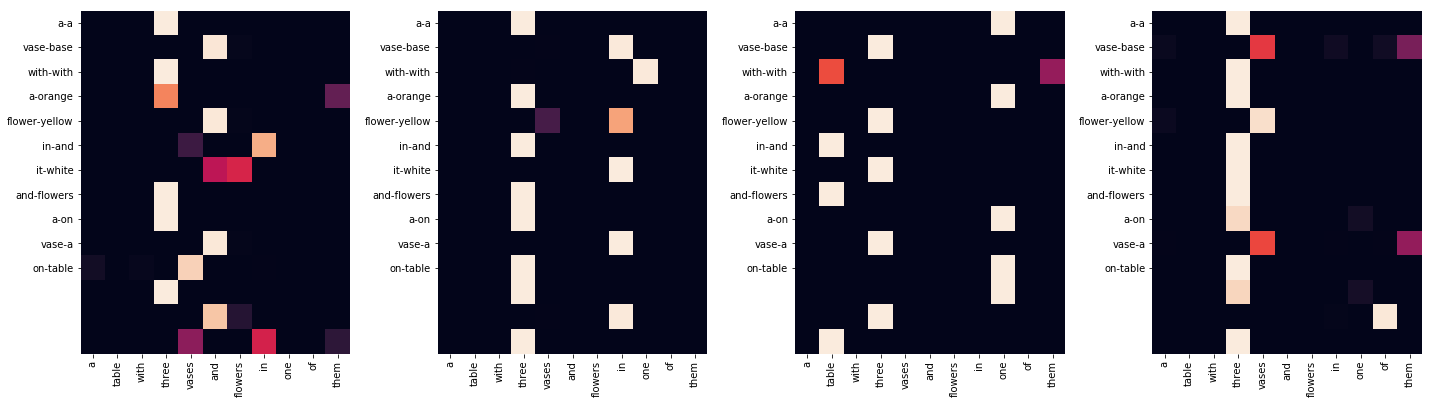

Visualizing layer 2


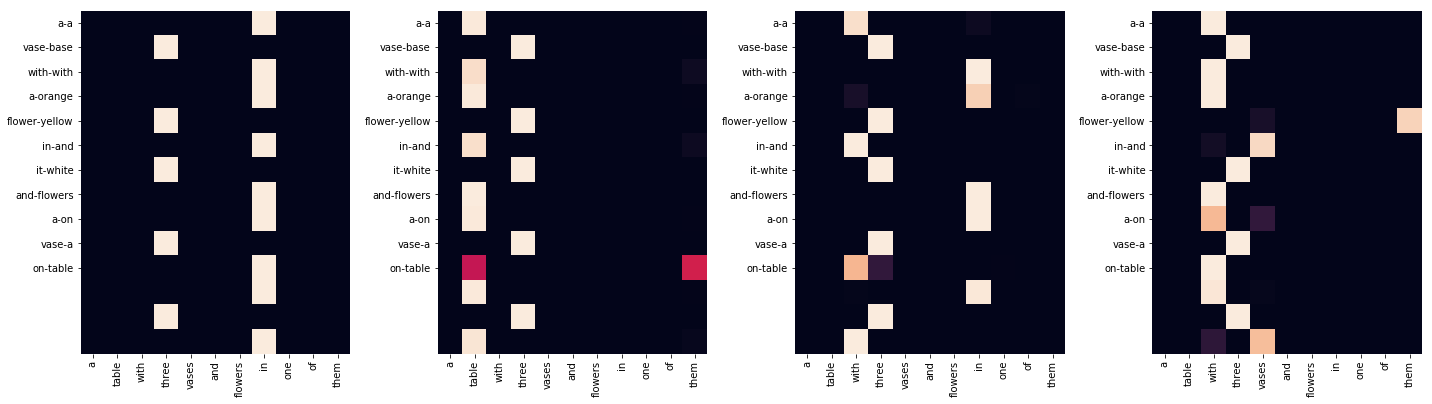

Visualizing layer 3


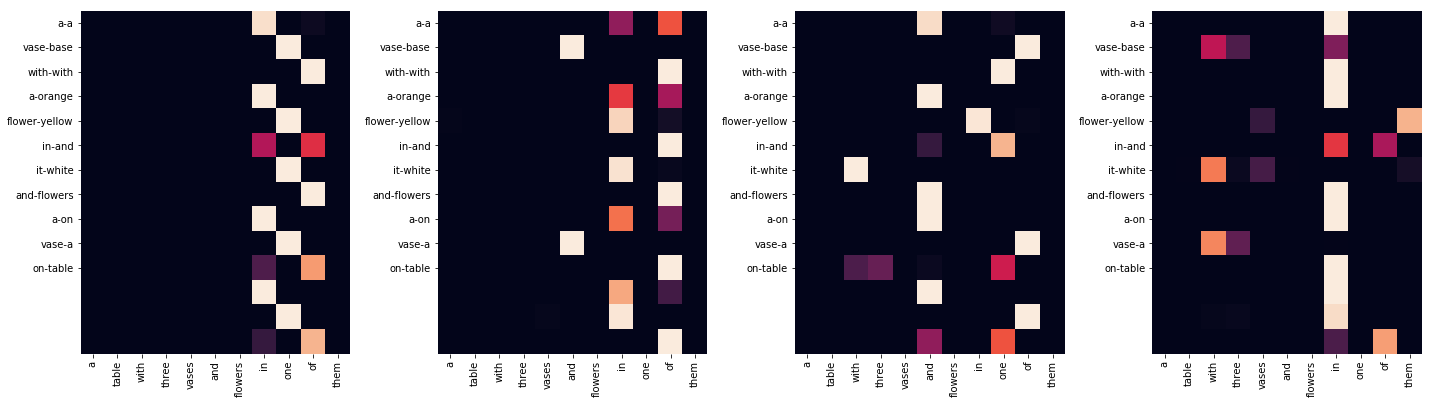

Visualizing layer 4


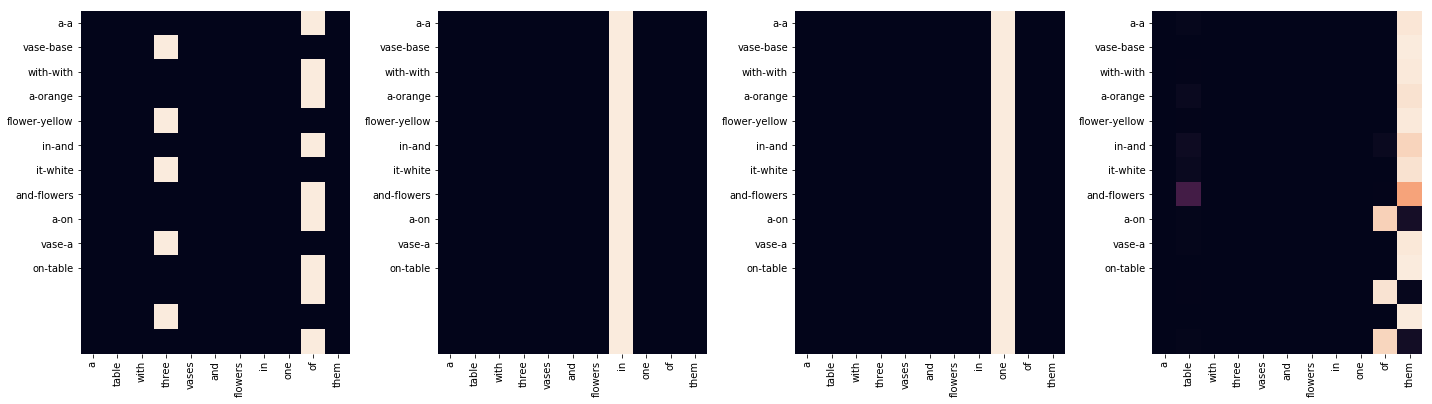

Visualizing layer 5


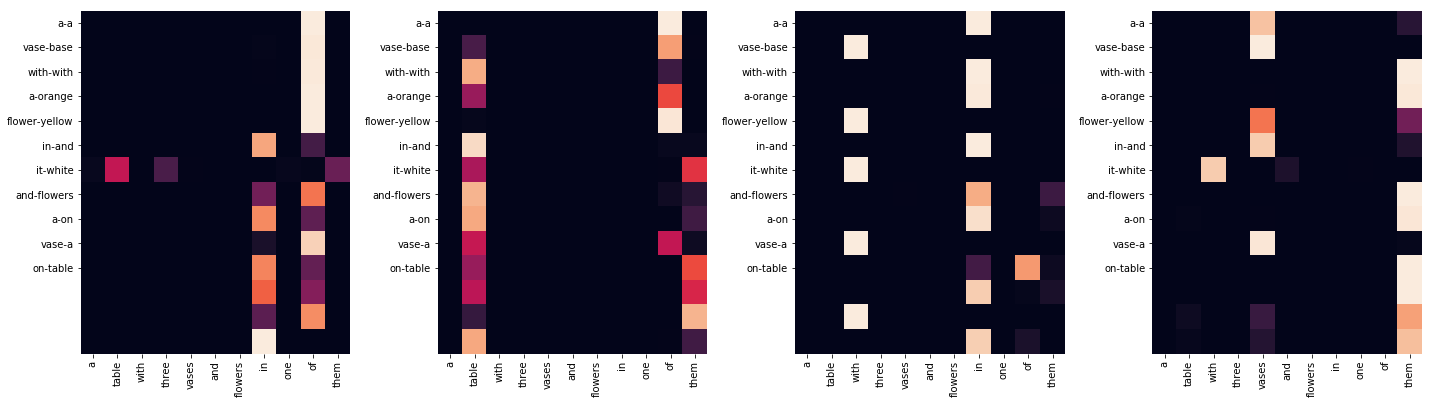

Visualizing layer 6


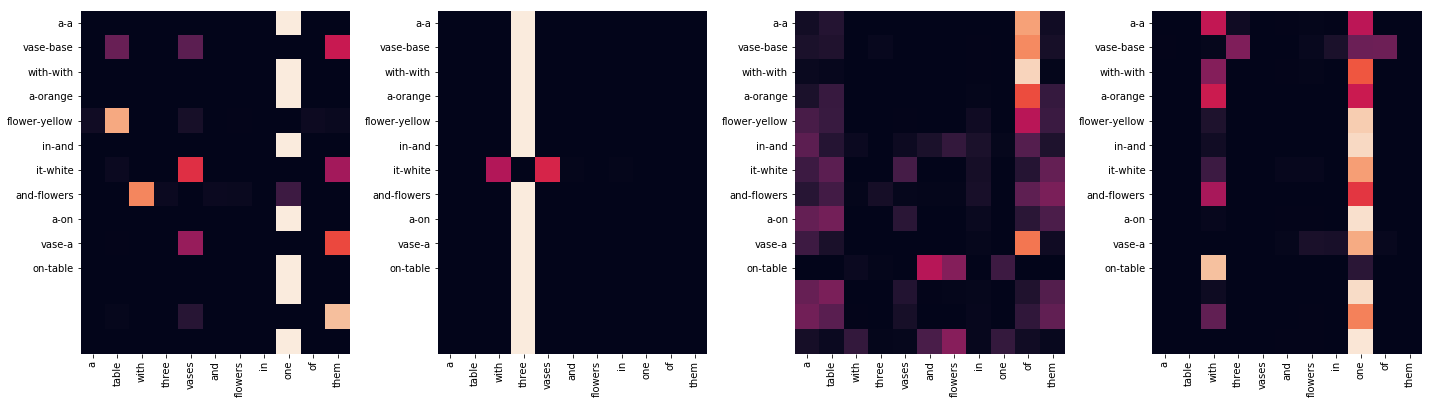

Example 2
SOURCE >> a polar bear near rock formations in an enclosed area
PRED   >> a polar bear walking across a lush green field next to a tree and trees
TARGET >> polar bear sits in enclosure looking up at the sky
[BLEU] 0.0526

Visualizing layer 1


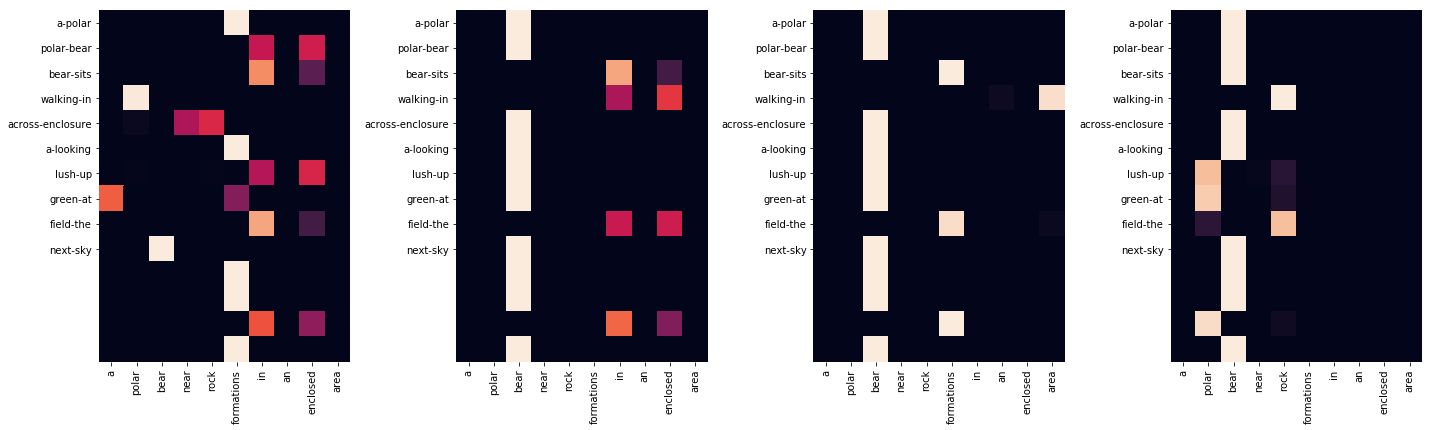

Visualizing layer 2


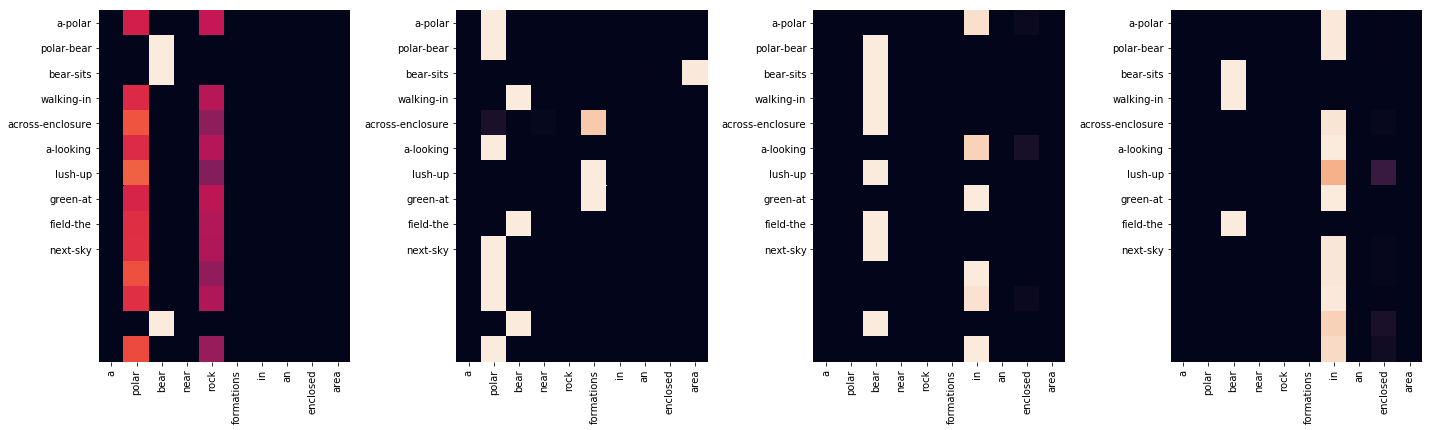

Visualizing layer 3


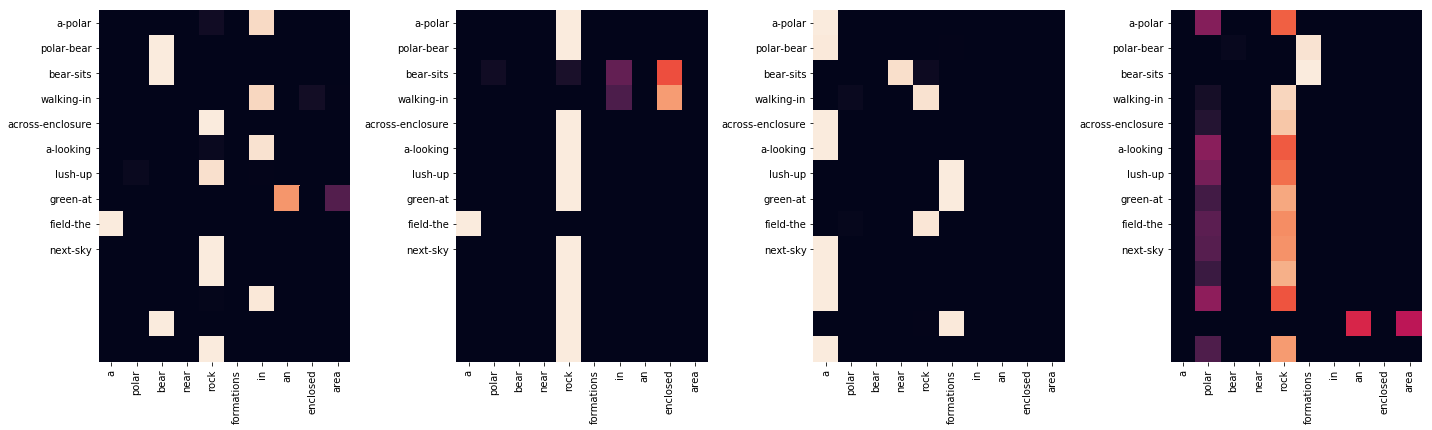

Visualizing layer 4


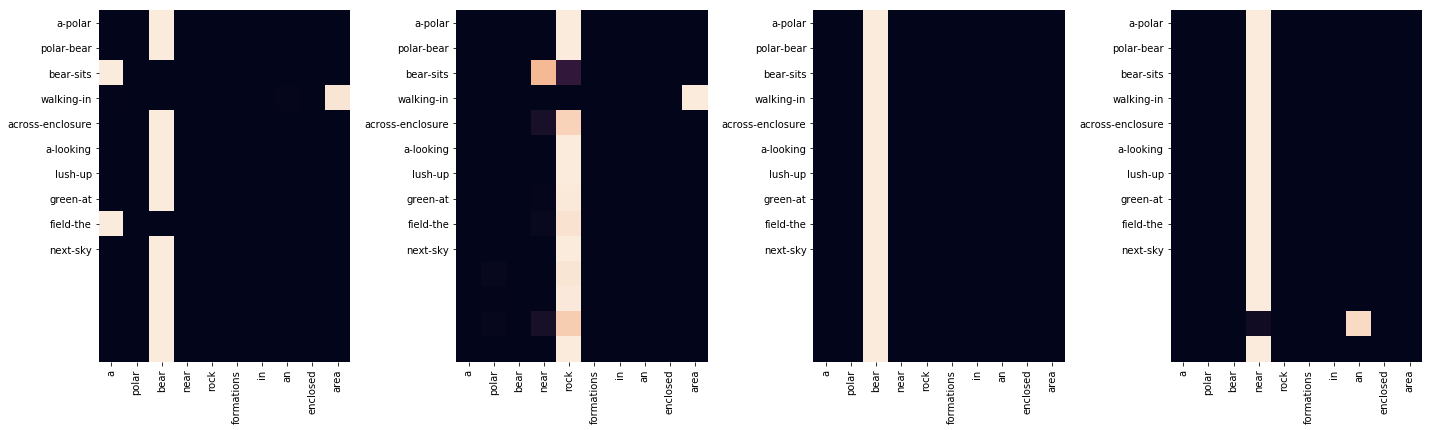

Visualizing layer 5


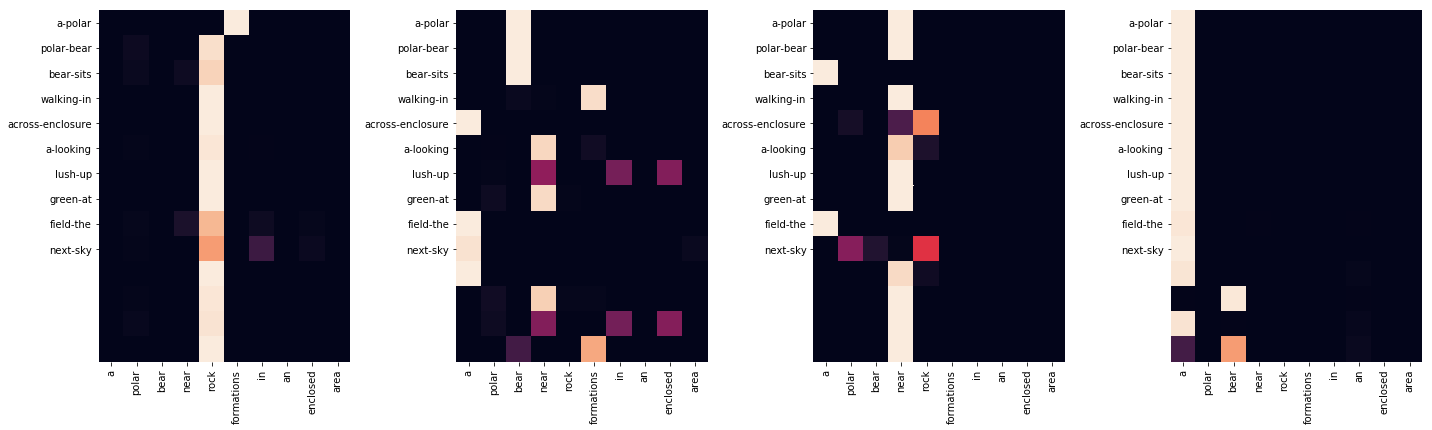

Visualizing layer 6


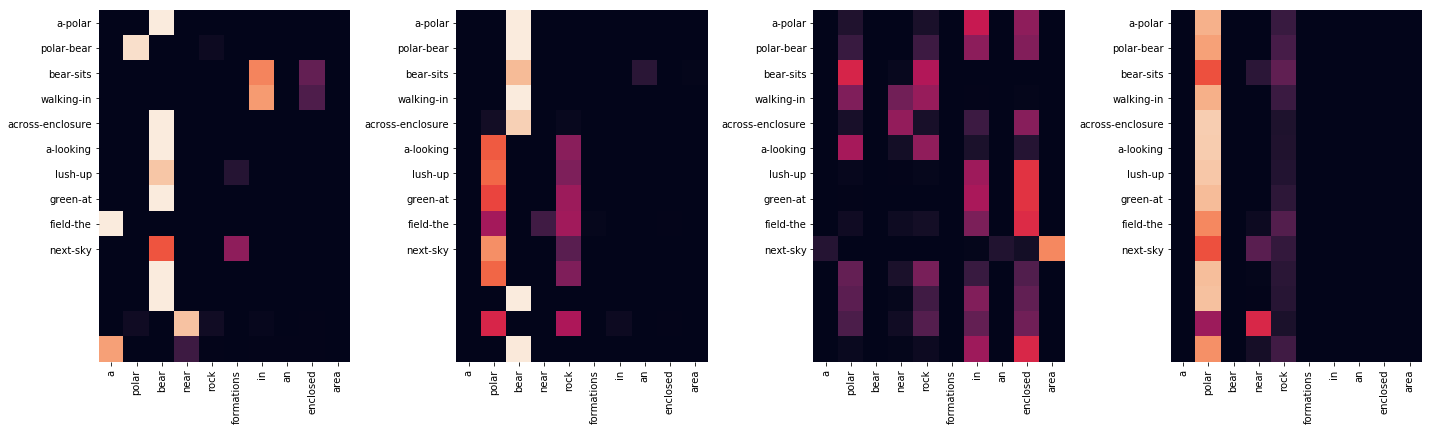

Example 3
SOURCE >> a woman standing on a tennis court holding a racquet
PRED   >> a woman is playing tennis on a tennis court with a racket and a tennis
TARGET >> a female tennis player about to hit a tennis ball
[BLEU] 0.0625

Visualizing layer 1


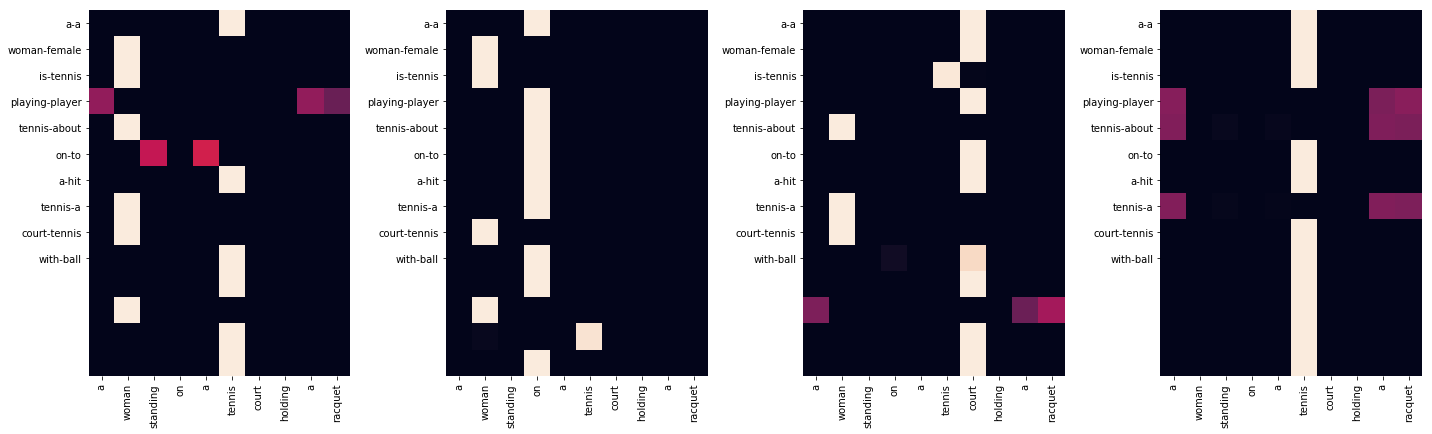

Visualizing layer 2


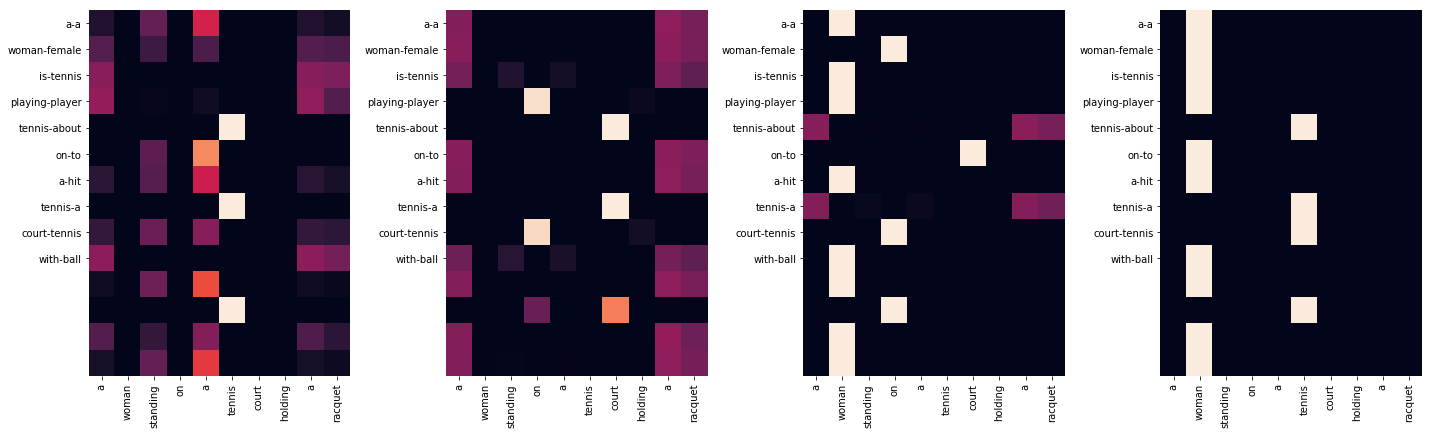

Visualizing layer 3


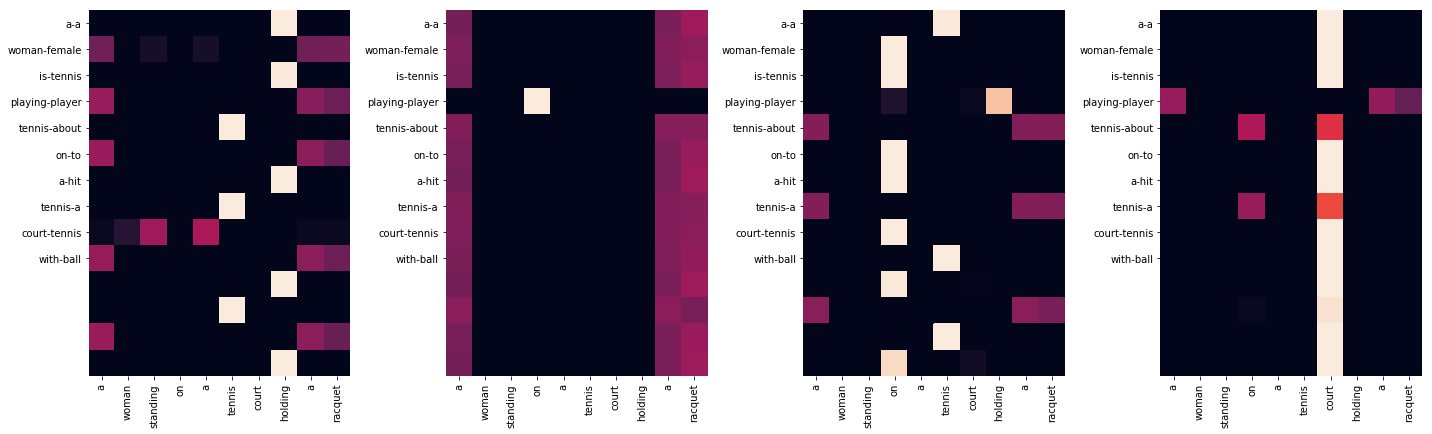

Visualizing layer 4


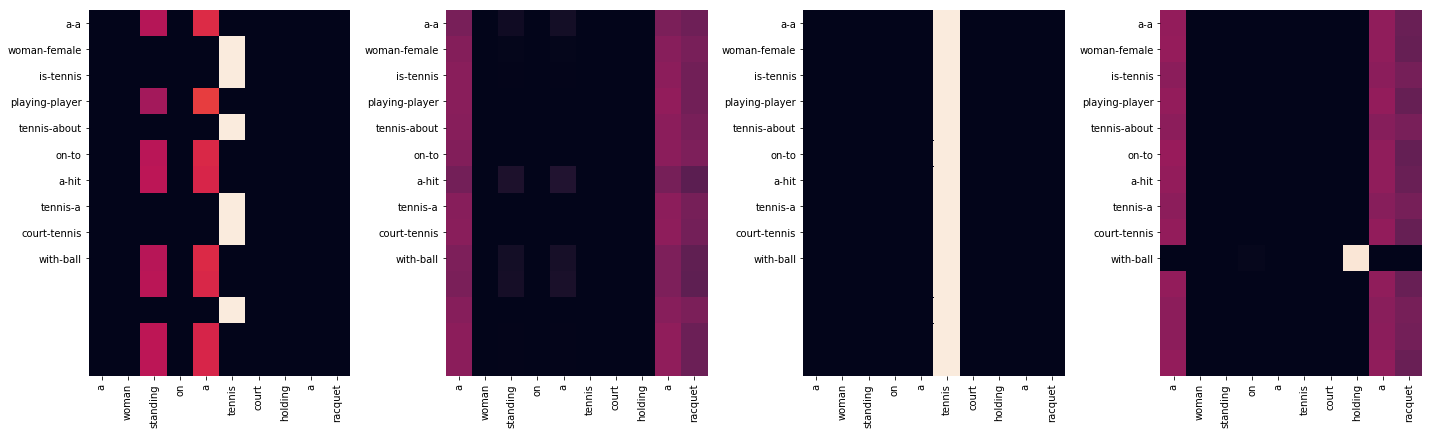

Visualizing layer 5


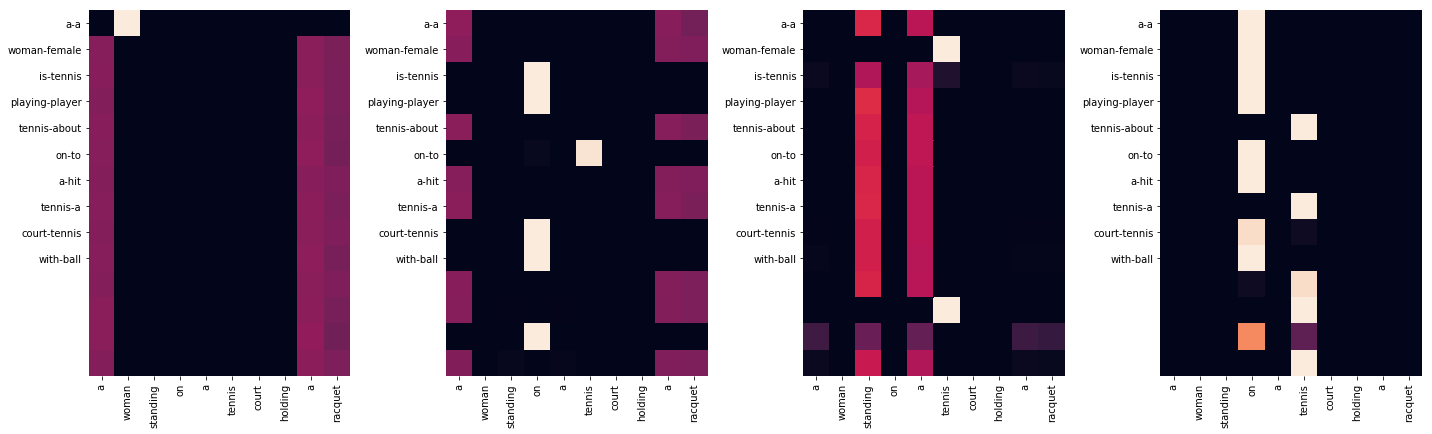

Visualizing layer 6


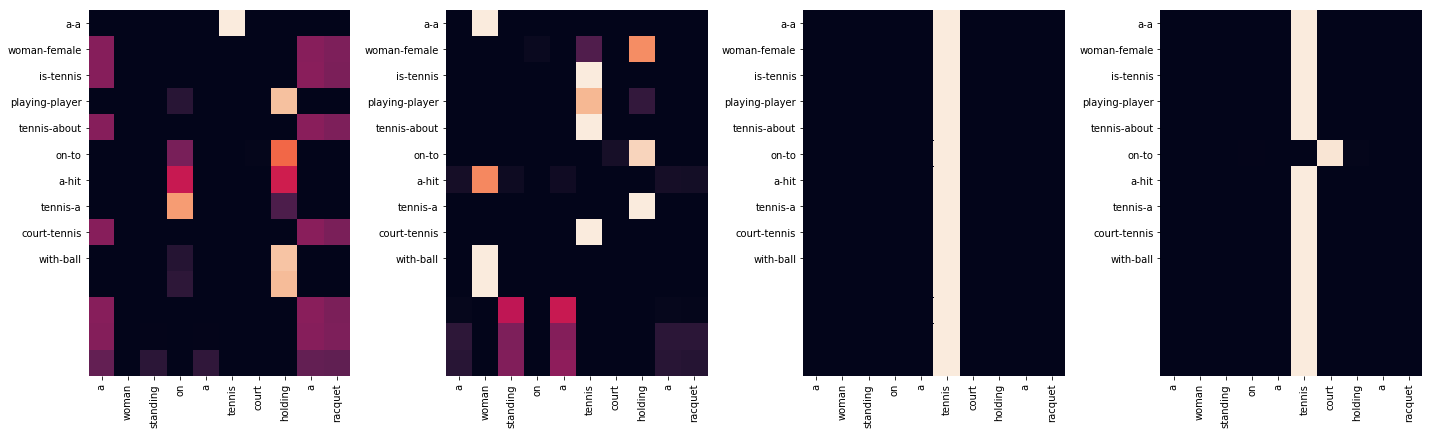

Example 4
SOURCE >> a yellow fire hydrant is standing alone in a parking garage
PRED   >> a yellow fire hydrant sitting on the side of a road next to a building
TARGET >> the shadow of a building being reflected onto another building
[BLEU] 0.0743

Visualizing layer 1


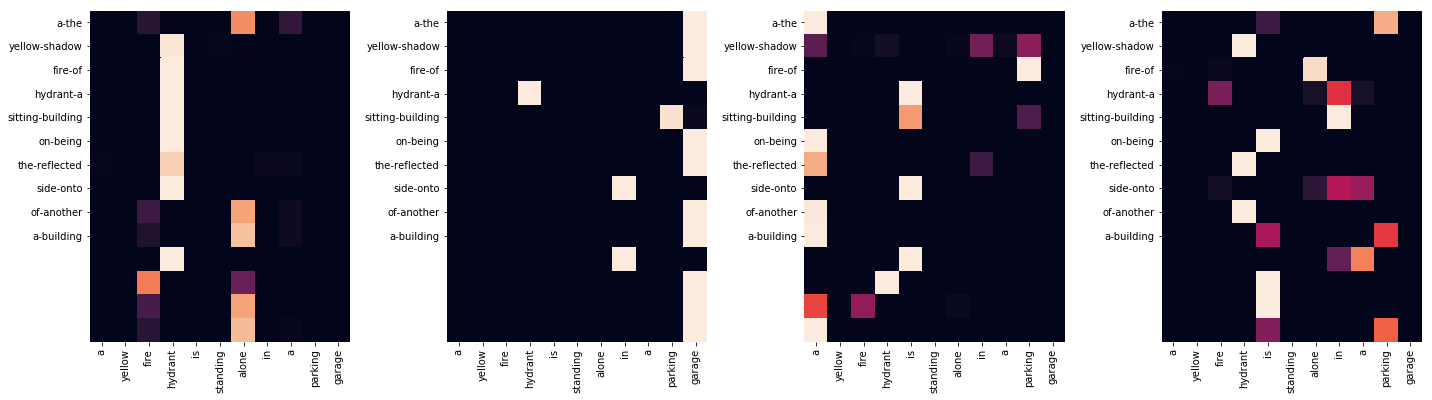

Visualizing layer 2


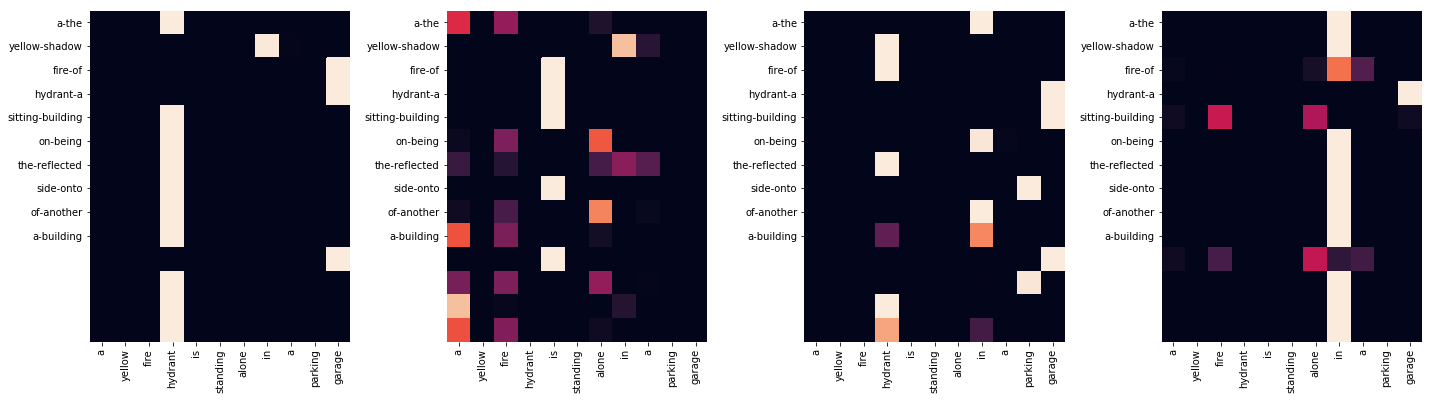

Visualizing layer 3


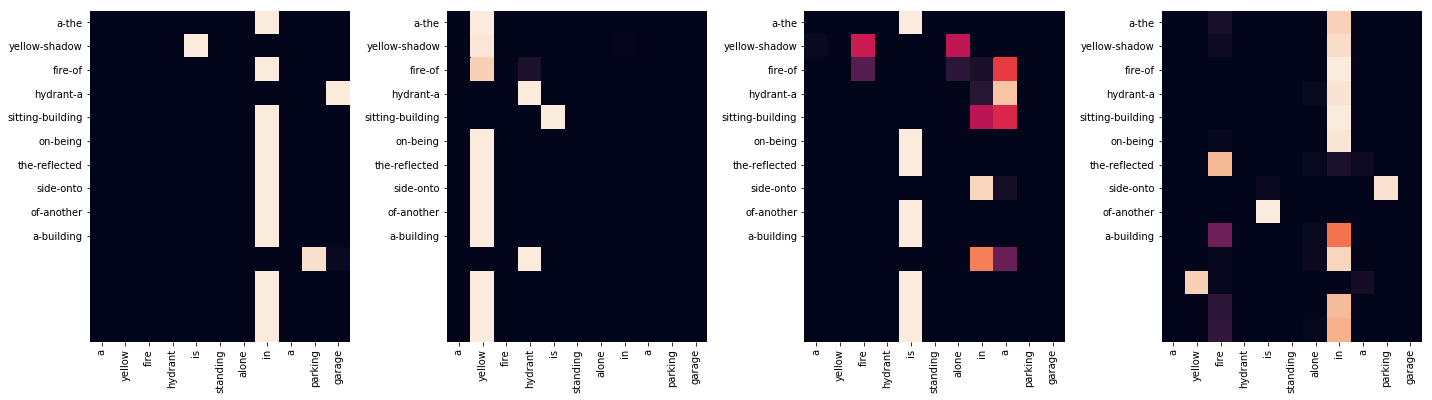

Visualizing layer 4


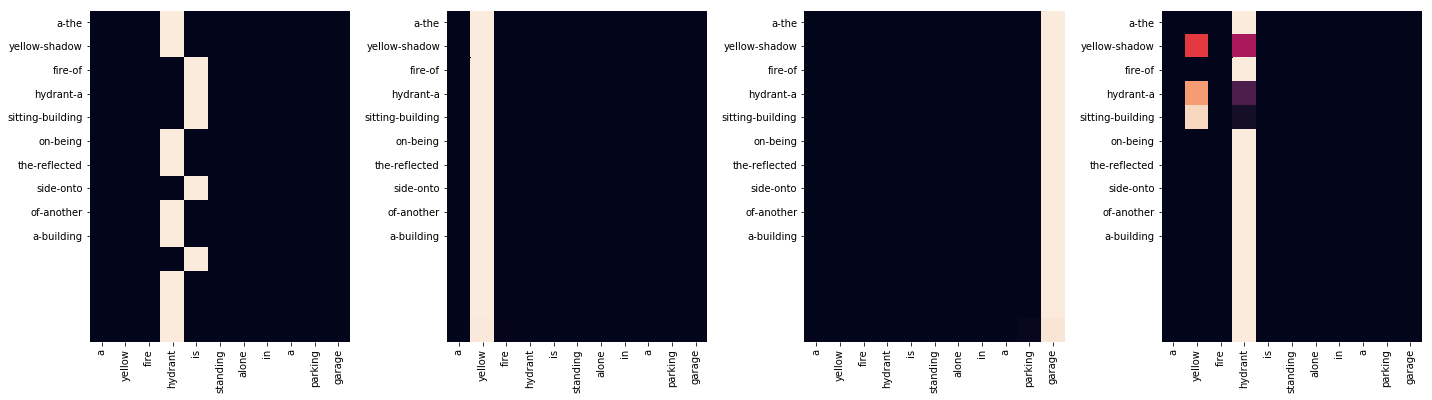

Visualizing layer 5


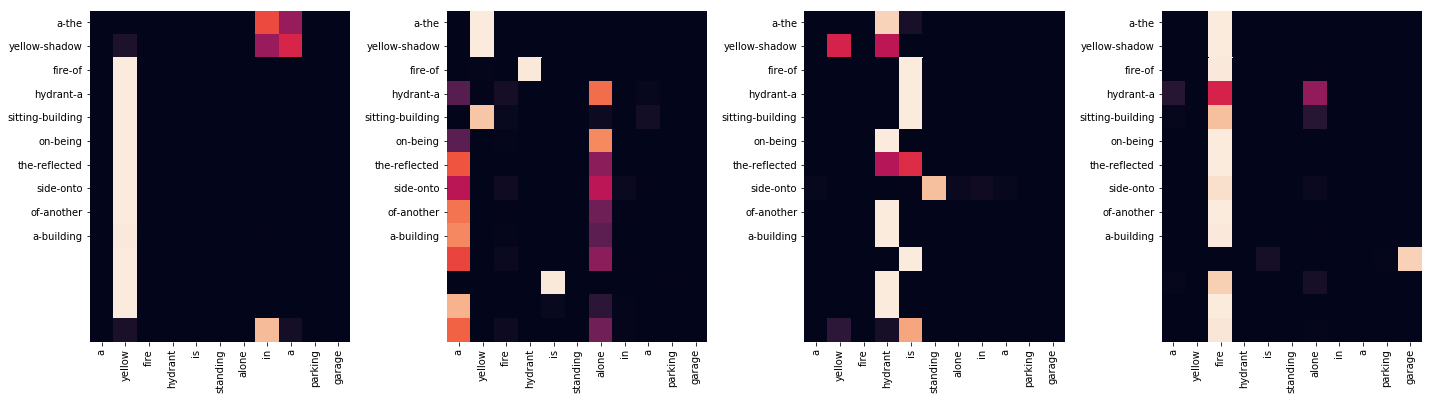

Visualizing layer 6


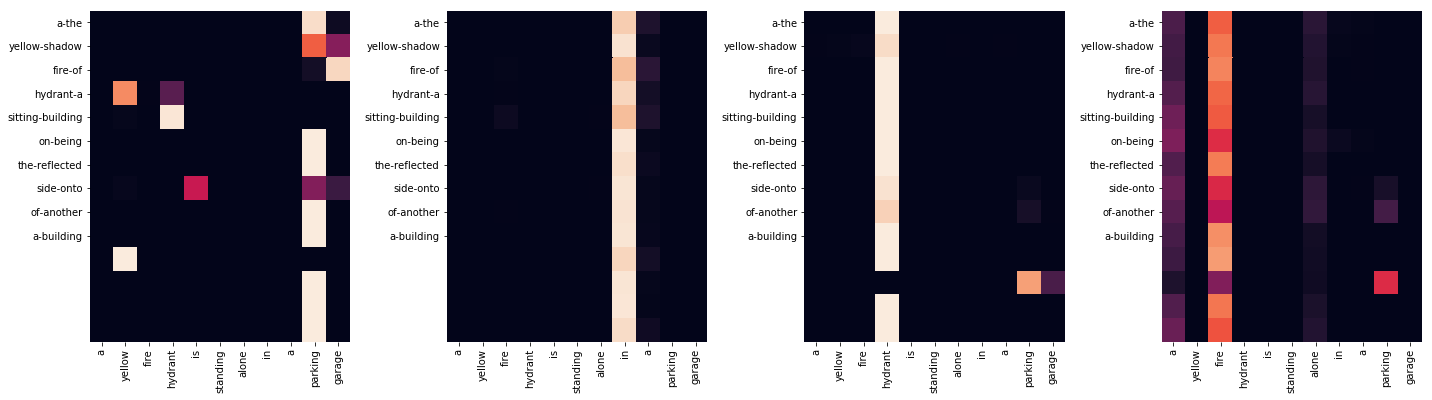

Example 5
SOURCE >> a giraffe that is eating some wood off a tree
PRED   >> a giraffe is eating some food from a tree branch in a zoo enclosure with
TARGET >> this giraffe looks like it is kissing the tree limb
[BLEU] 0.0346

Visualizing layer 1


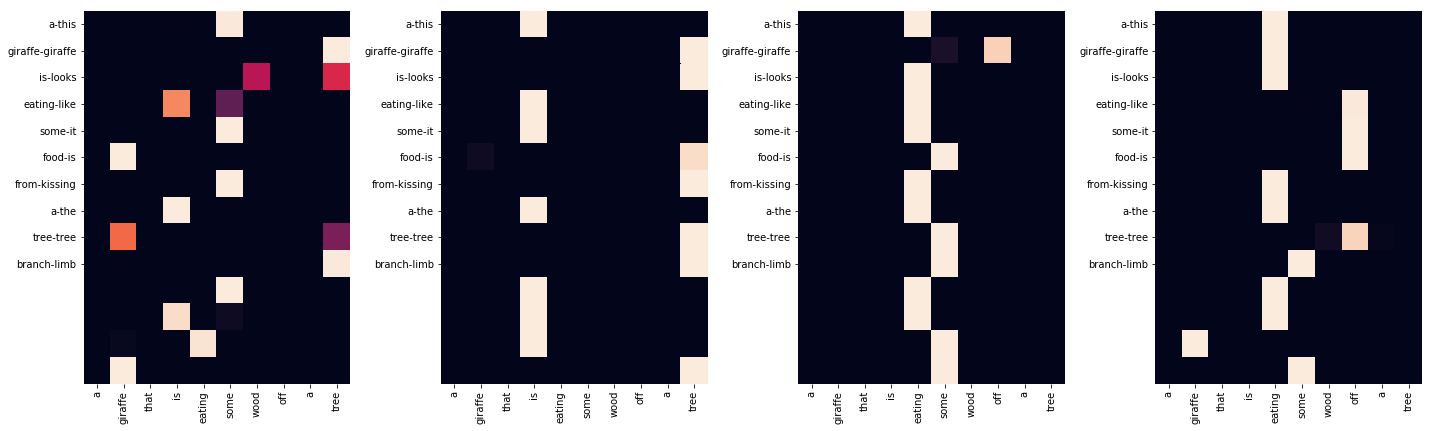

Visualizing layer 2


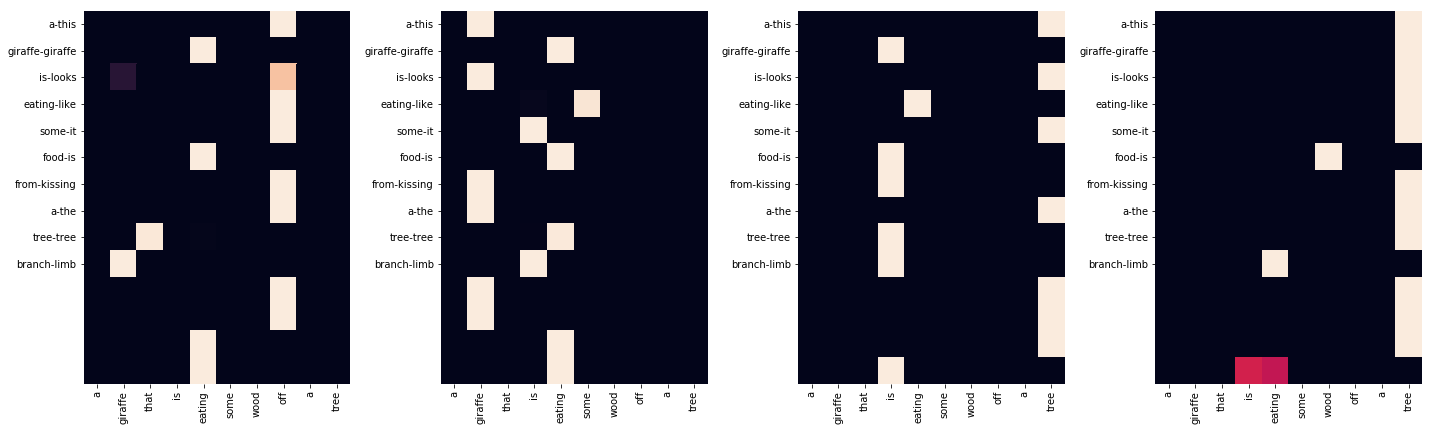

Visualizing layer 3


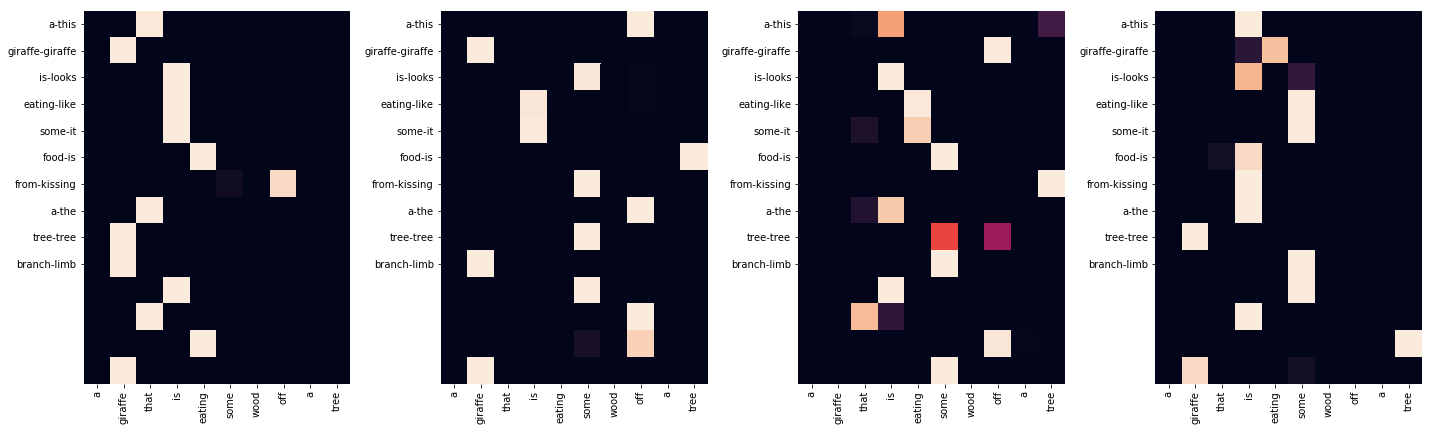

Visualizing layer 4


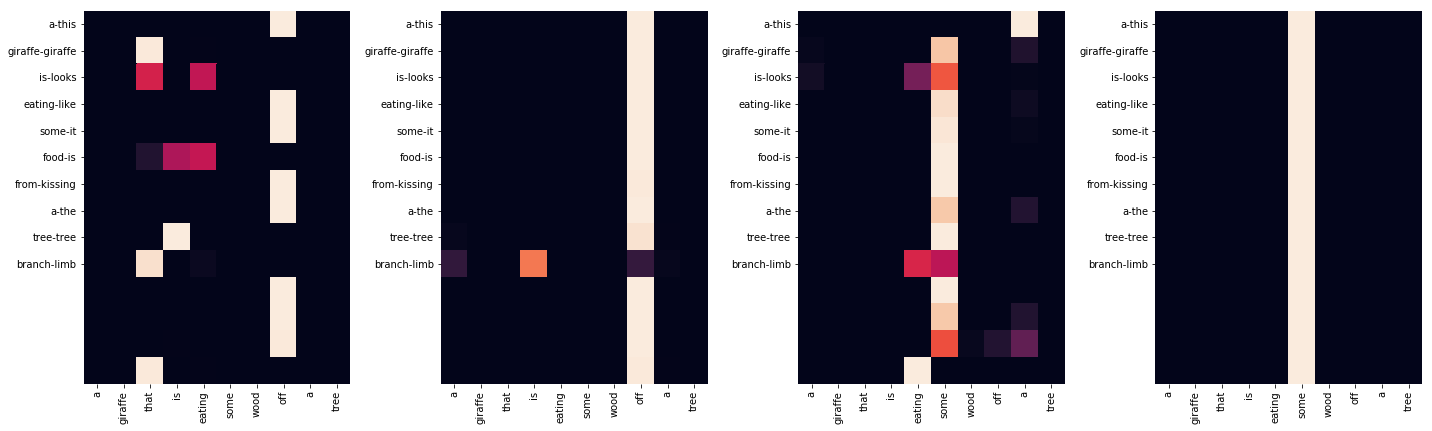

Visualizing layer 5


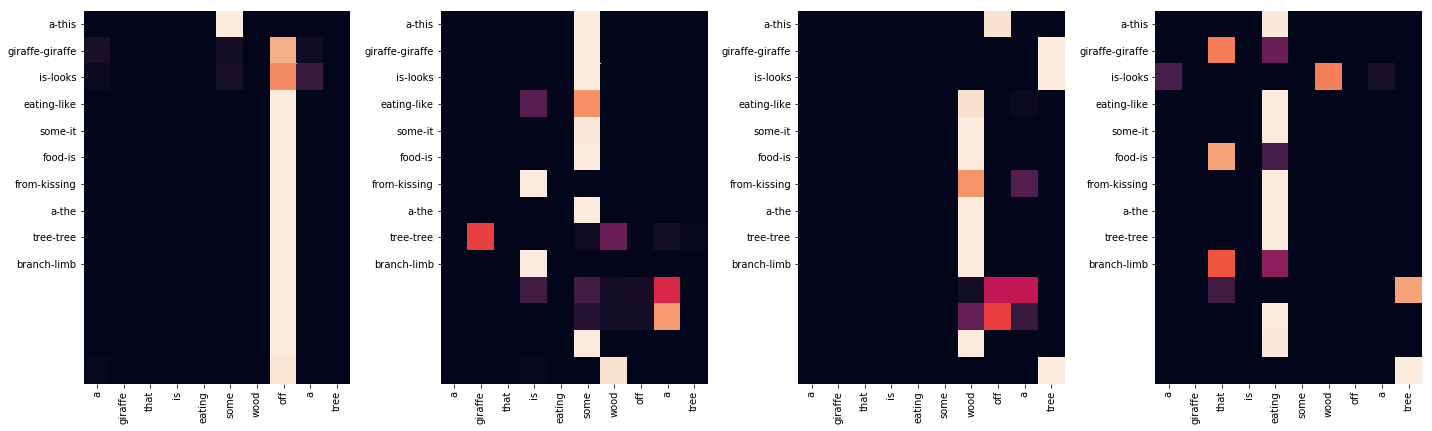

Visualizing layer 6


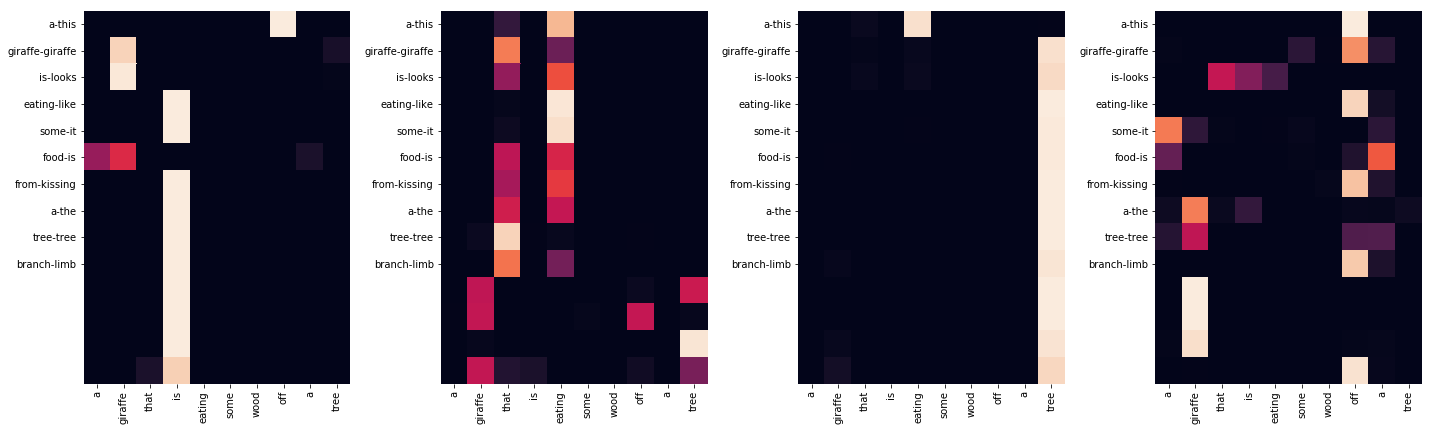

Example 6
SOURCE >> black and white photograph of a girl wearing a hat
PRED   >> a woman is holding a small child and a small child with a frisbee in
TARGET >> a woman making gestures with hands in black and white
[BLEU] 0.0661

Visualizing layer 1


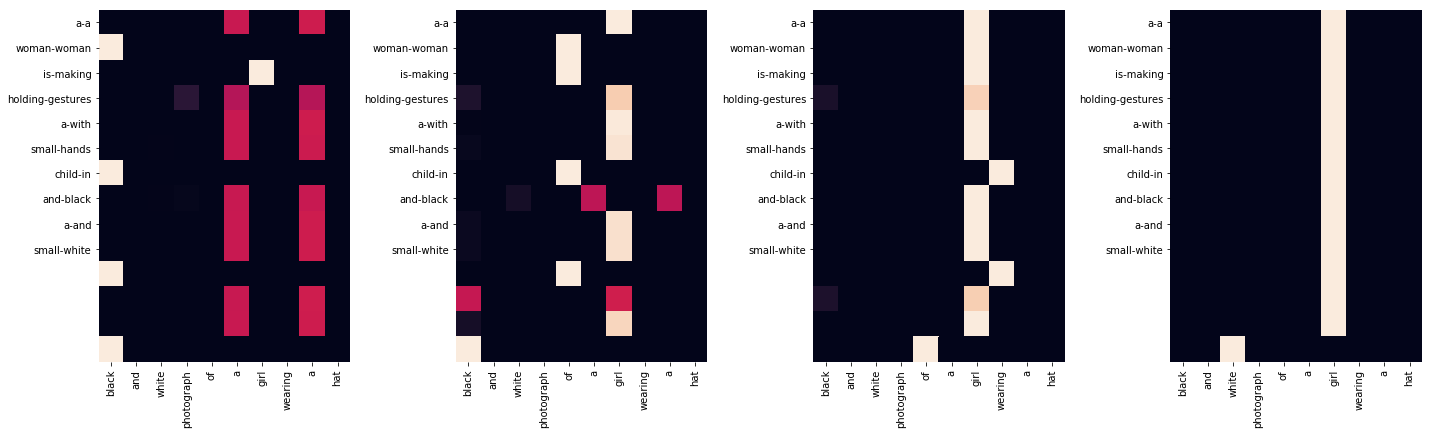

Visualizing layer 2


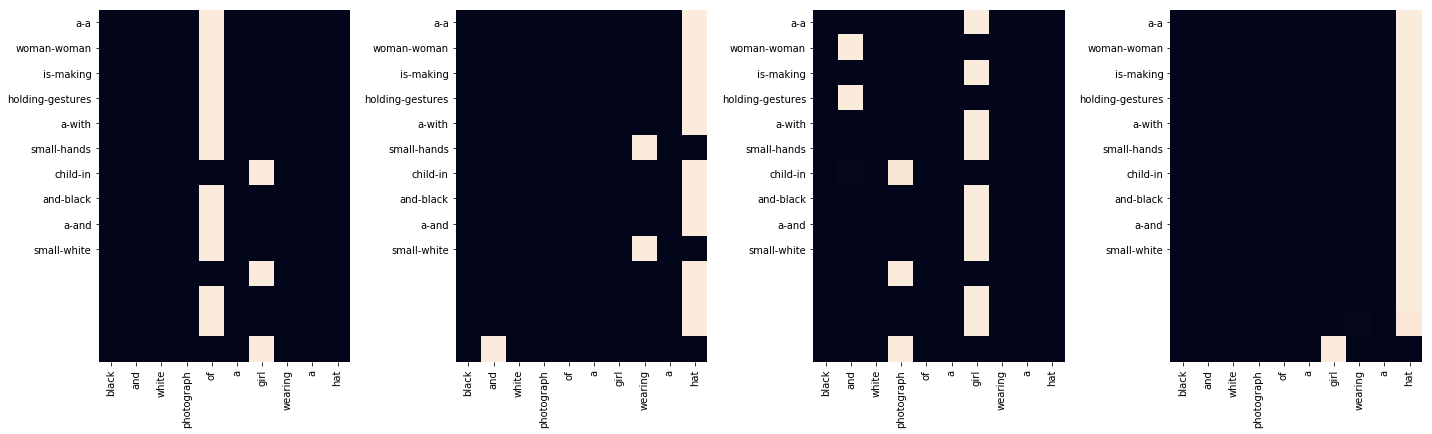

Visualizing layer 3


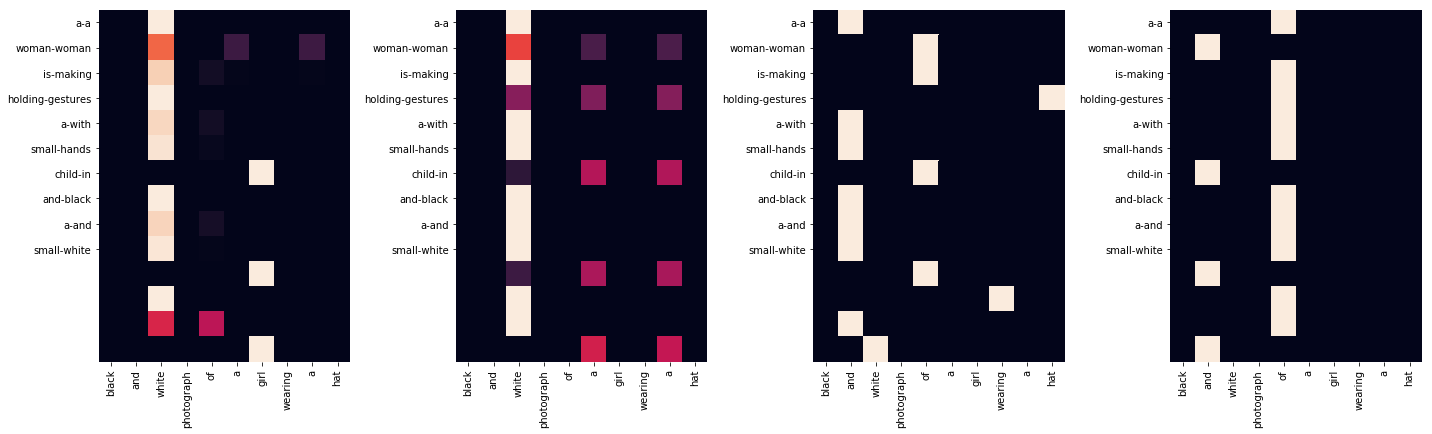

Visualizing layer 4


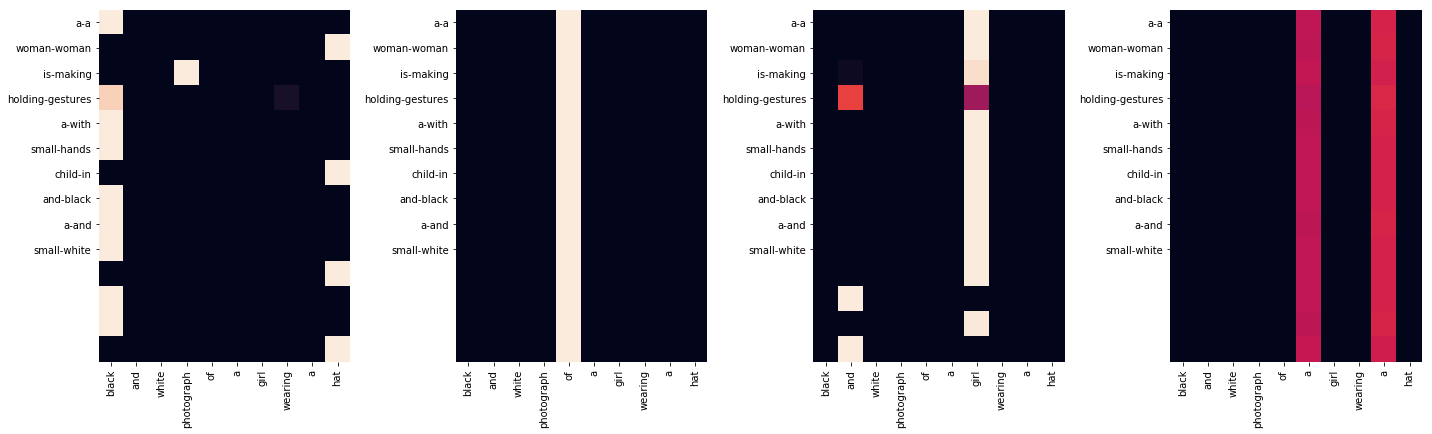

Visualizing layer 5


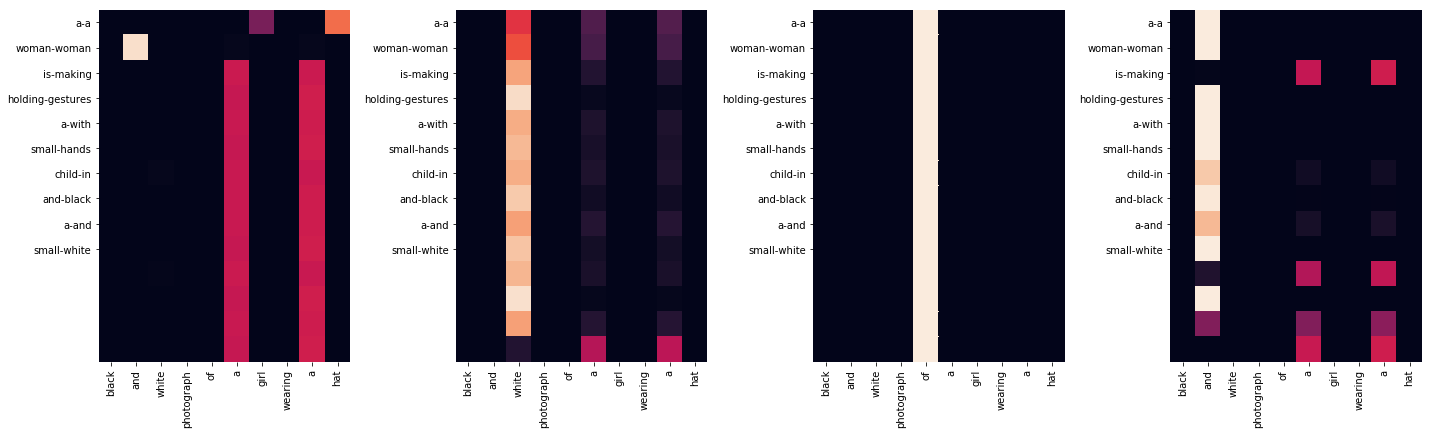

Visualizing layer 6


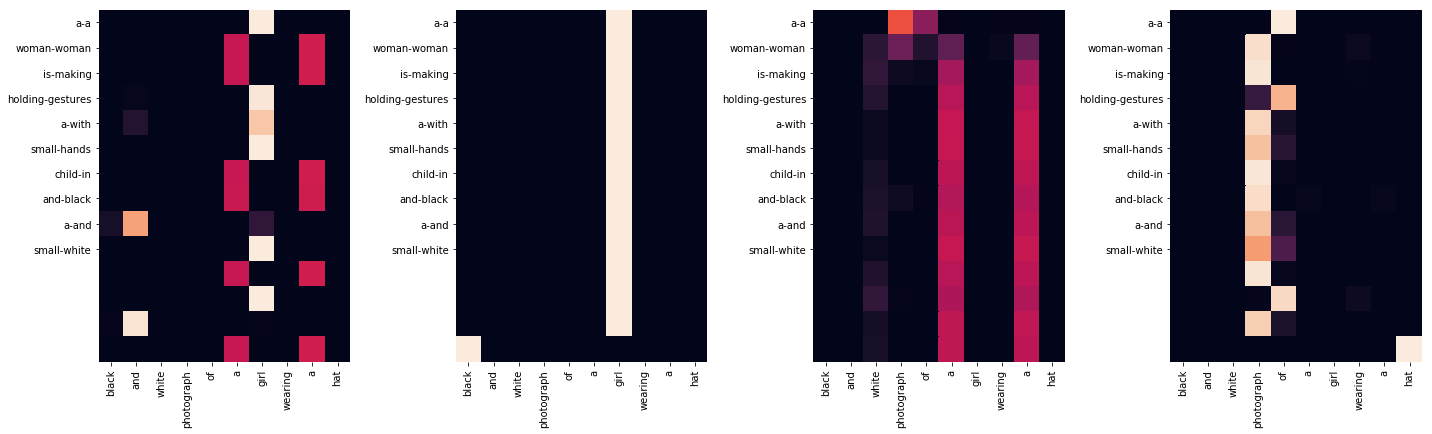

Example 7
SOURCE >> people in a park by a pond with swans and ducks
PRED   >> a group of people standing on top of a lush green field with a kite
TARGET >> this must be the boston commons on a spring day when there is a light drizzle
[BLEU] 0.0324

Visualizing layer 1


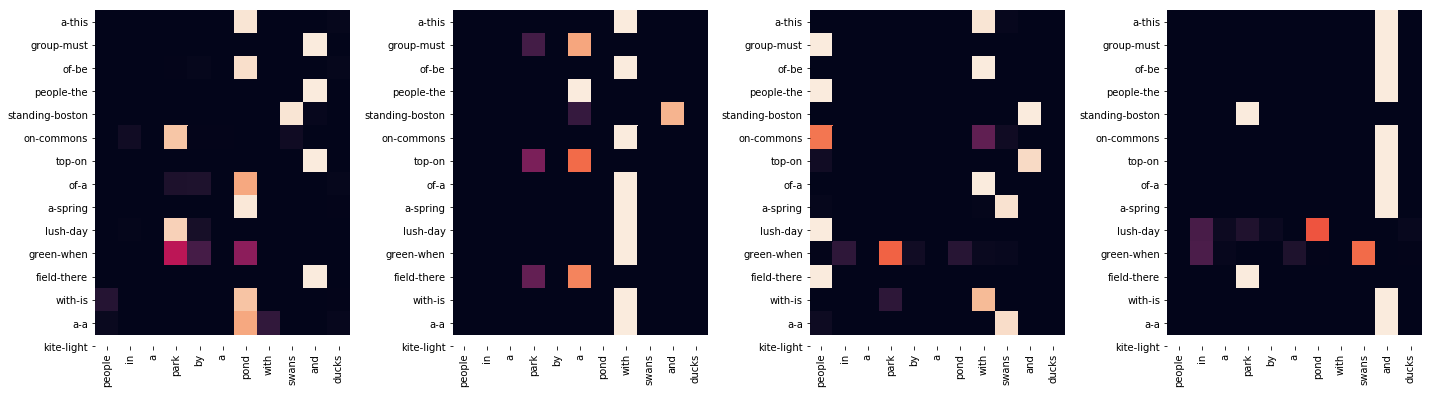

Visualizing layer 2


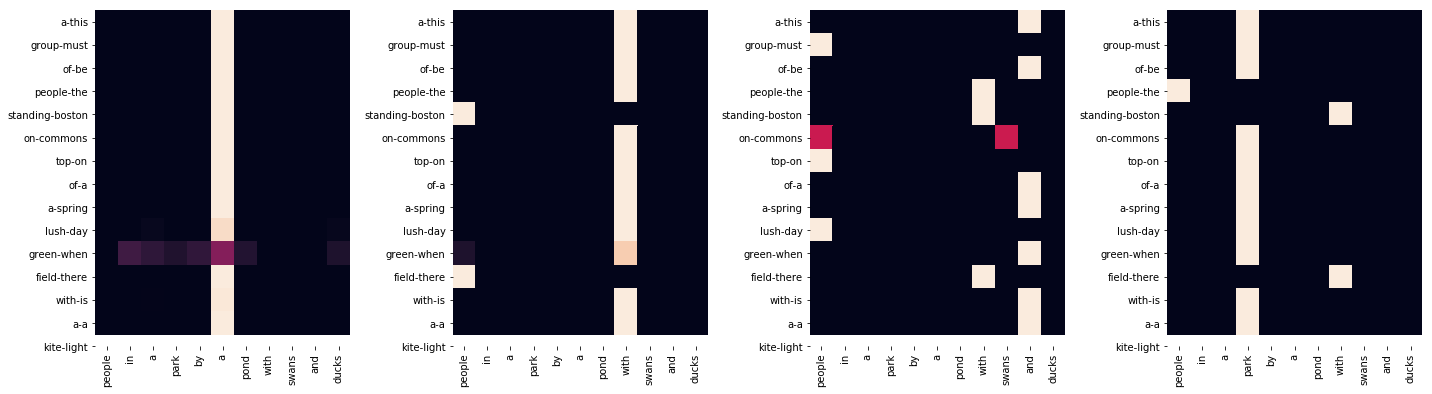

Visualizing layer 3


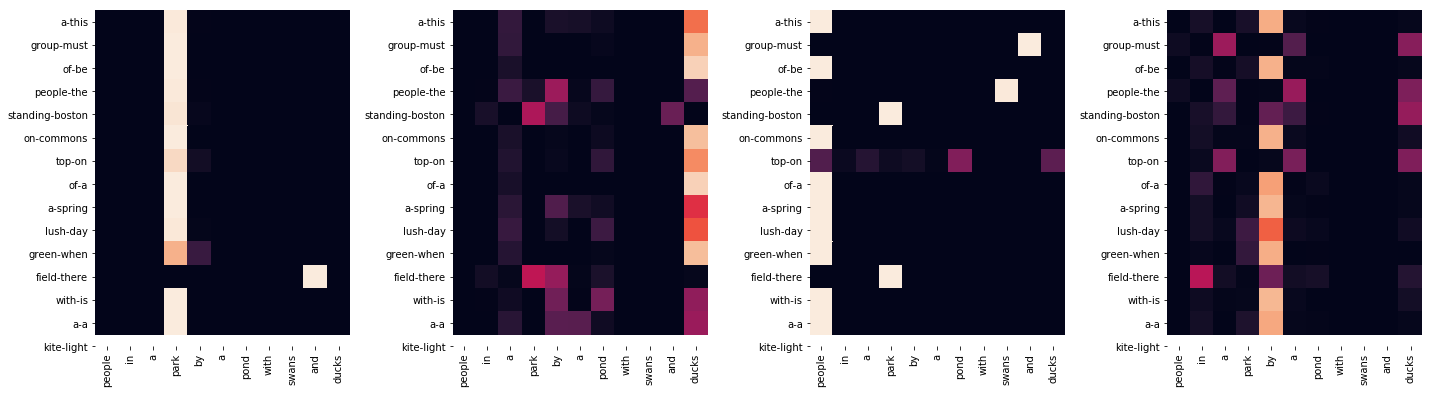

Visualizing layer 4


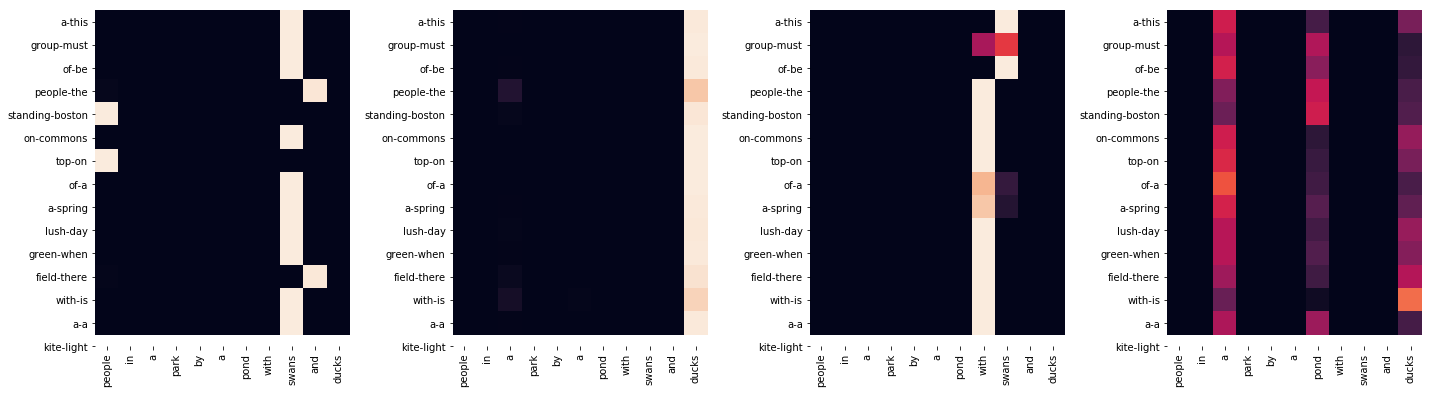

Visualizing layer 5


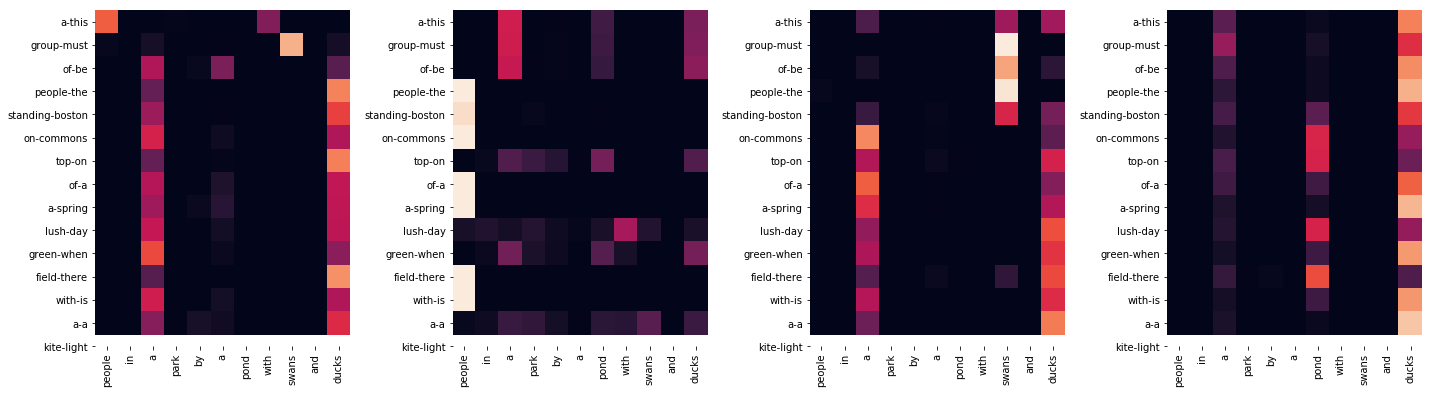

Visualizing layer 6


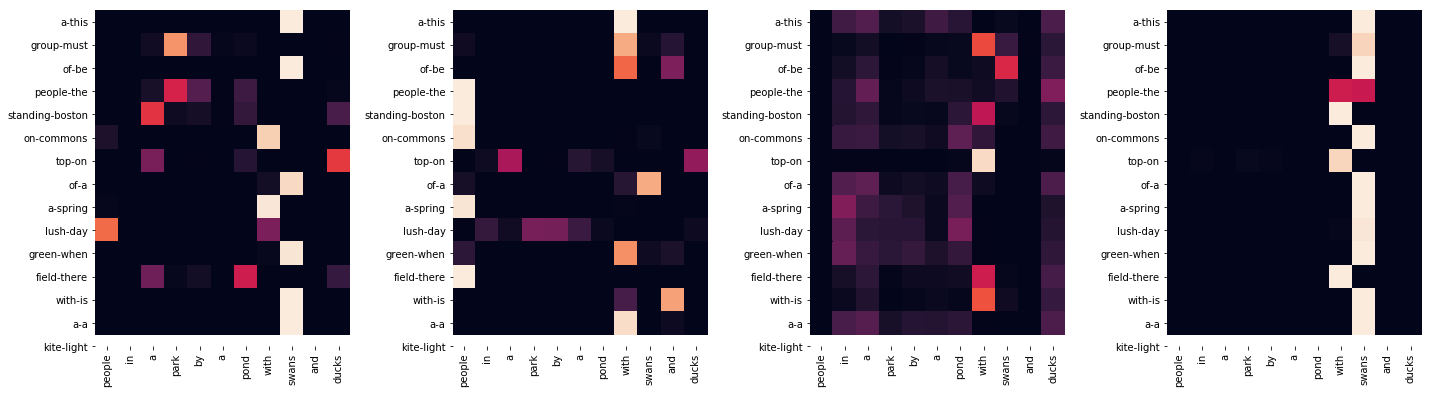

Example 8
SOURCE >> we are looking at a formal living room
PRED   >> a living room with a couch and a table and a table and a table
TARGET >> a coffee table is standing in a living room
[BLEU] 0.1111

Visualizing layer 1


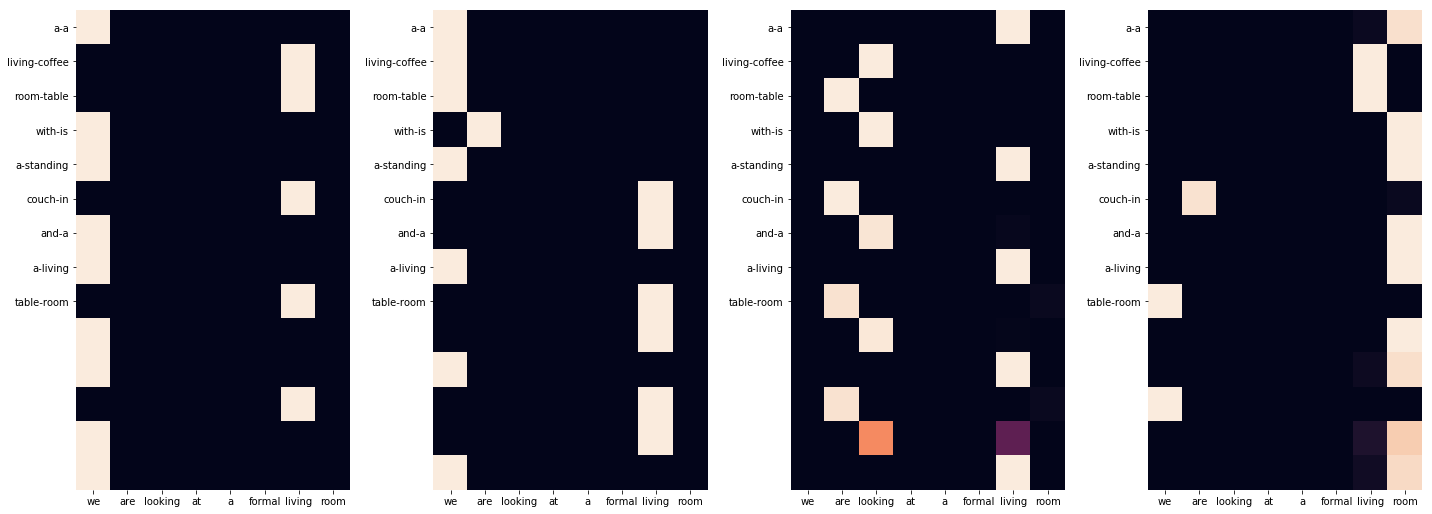

Visualizing layer 2


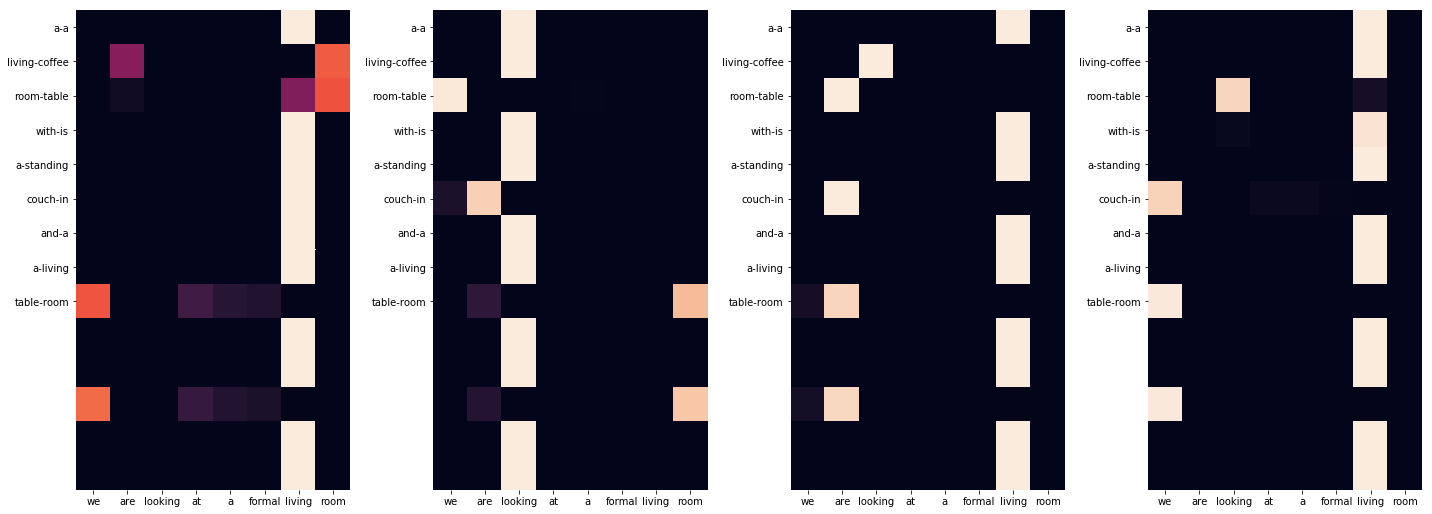

Visualizing layer 3


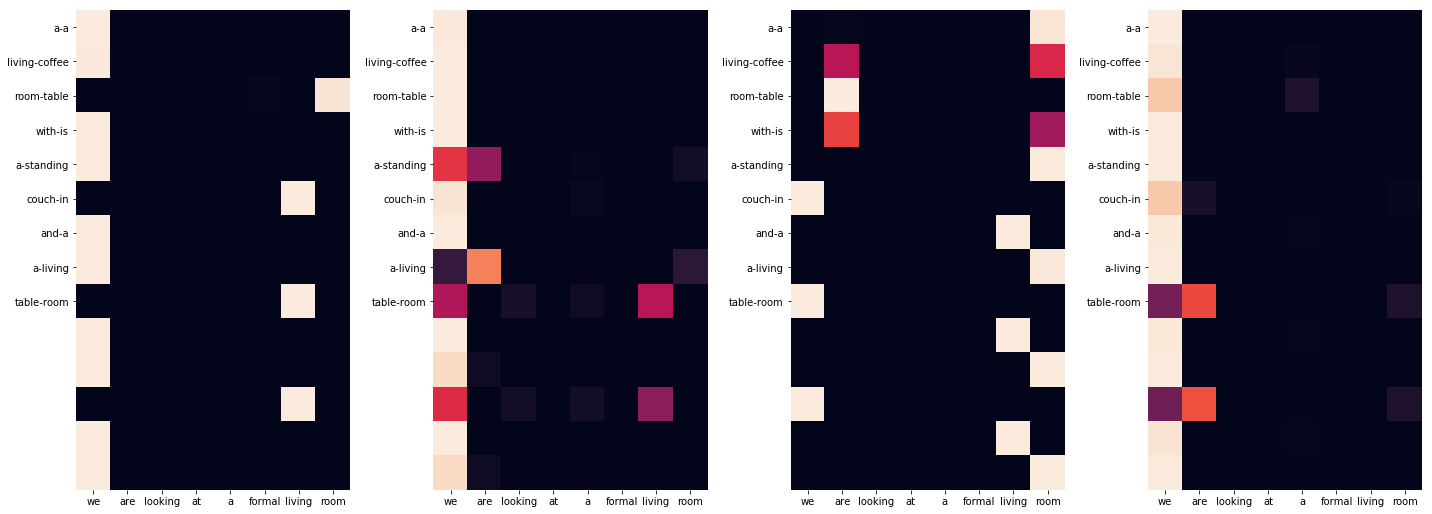

Visualizing layer 4


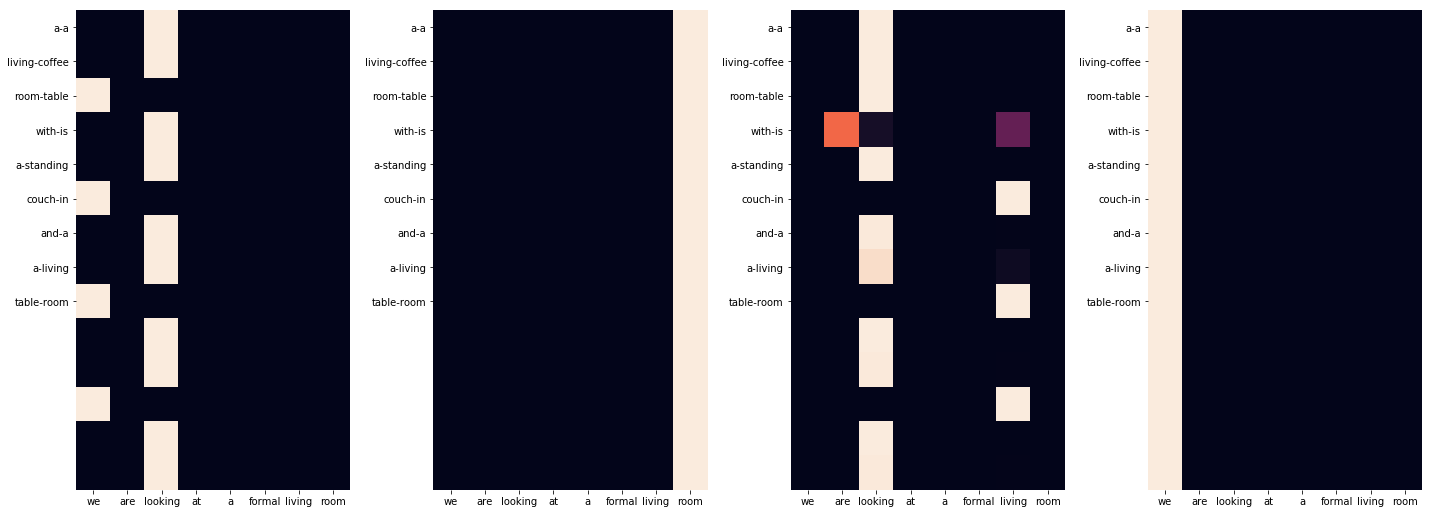

Visualizing layer 5


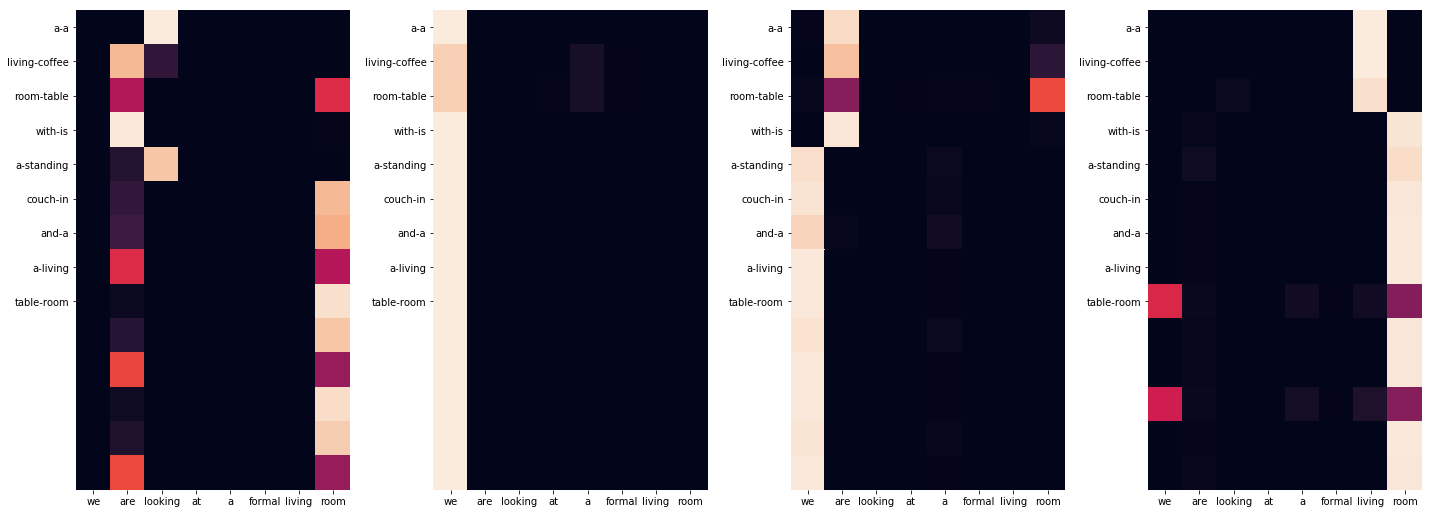

Visualizing layer 6


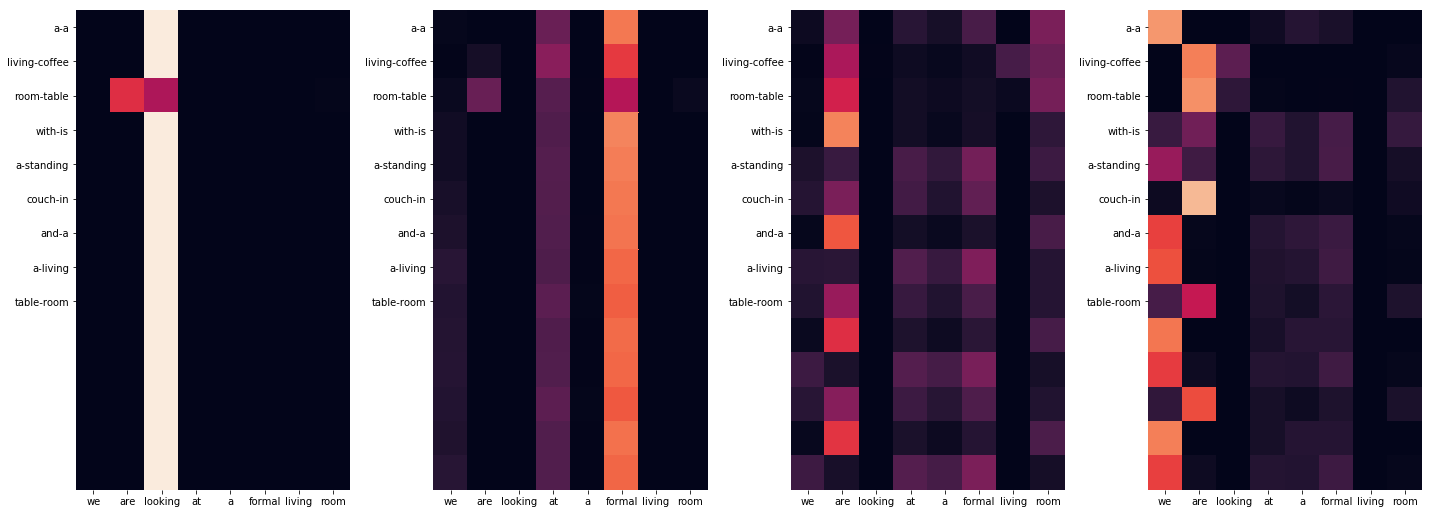

Example 9
SOURCE >> a person riding a horse on top of a sandy beach
PRED   >> a man riding a horse on a beach next to a fence in the ocean
TARGET >> a woman on a horse on the shore of the ocean
[BLEU] 0.1383

Visualizing layer 1


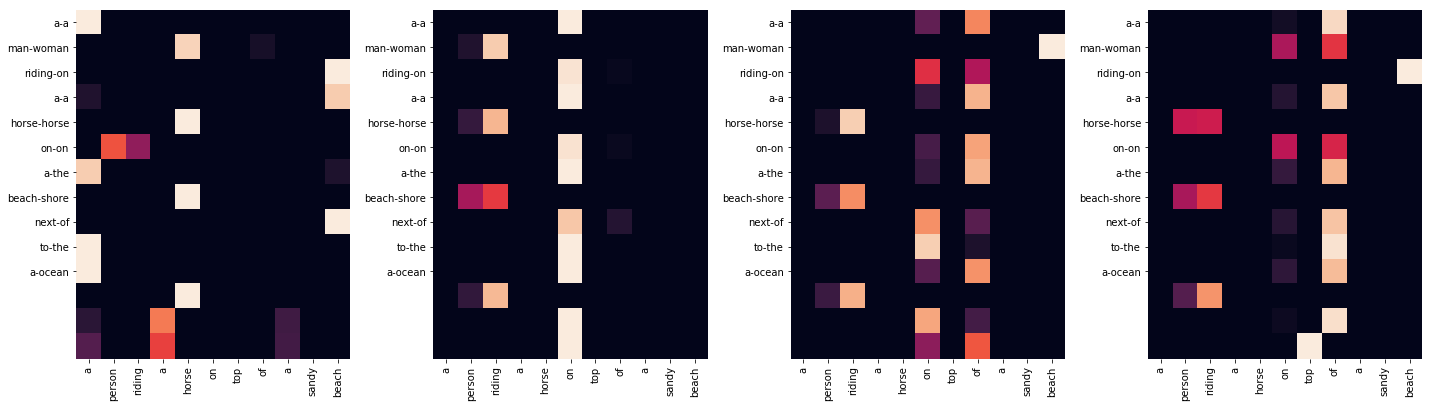

Visualizing layer 2


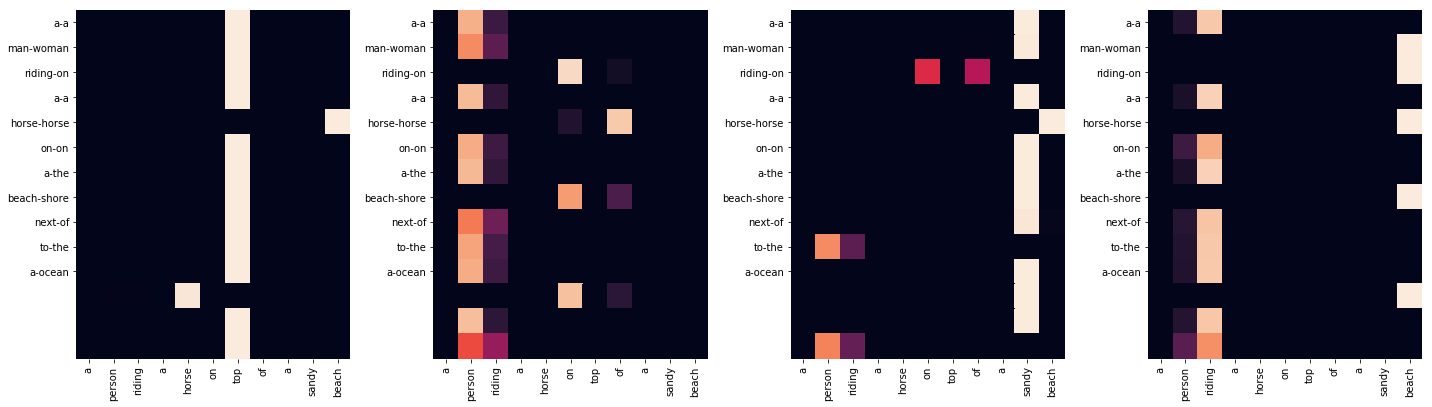

Visualizing layer 3


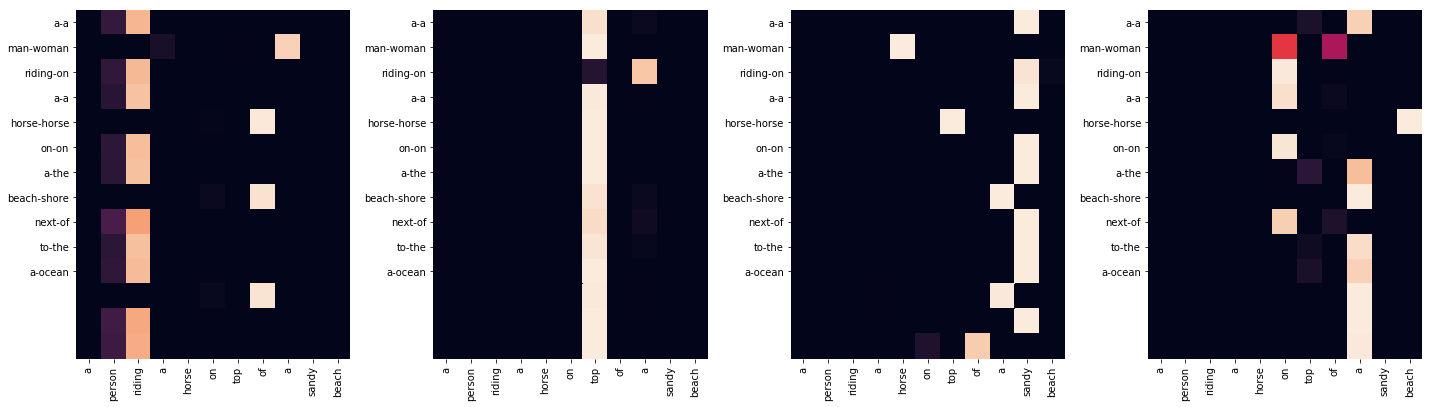

Visualizing layer 4


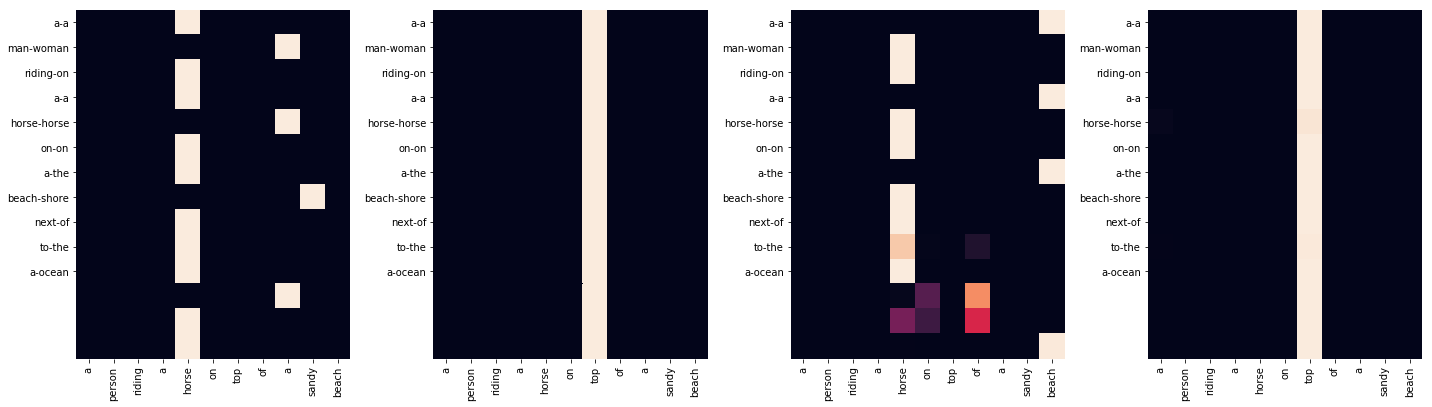

Visualizing layer 5


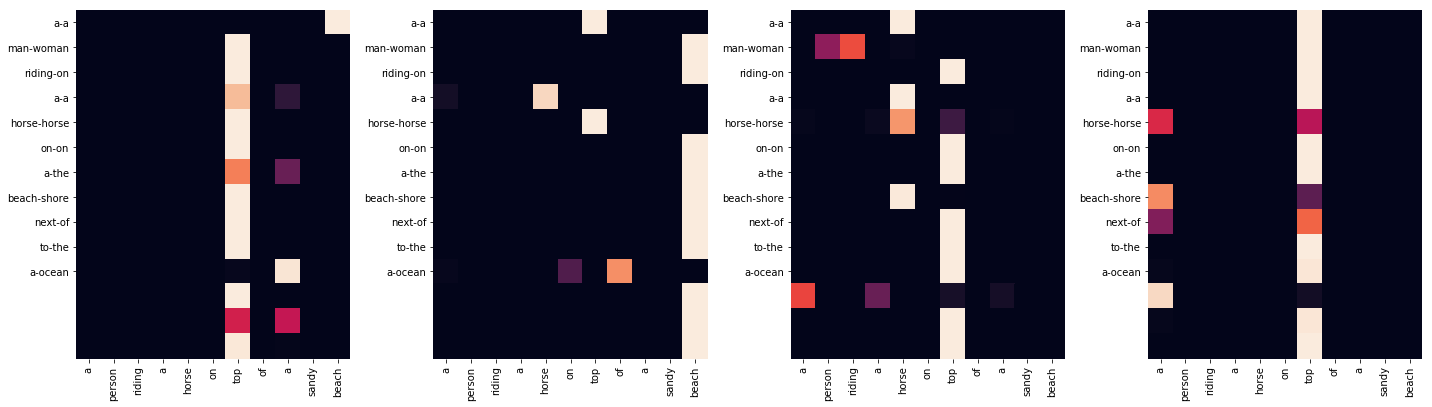

Visualizing layer 6


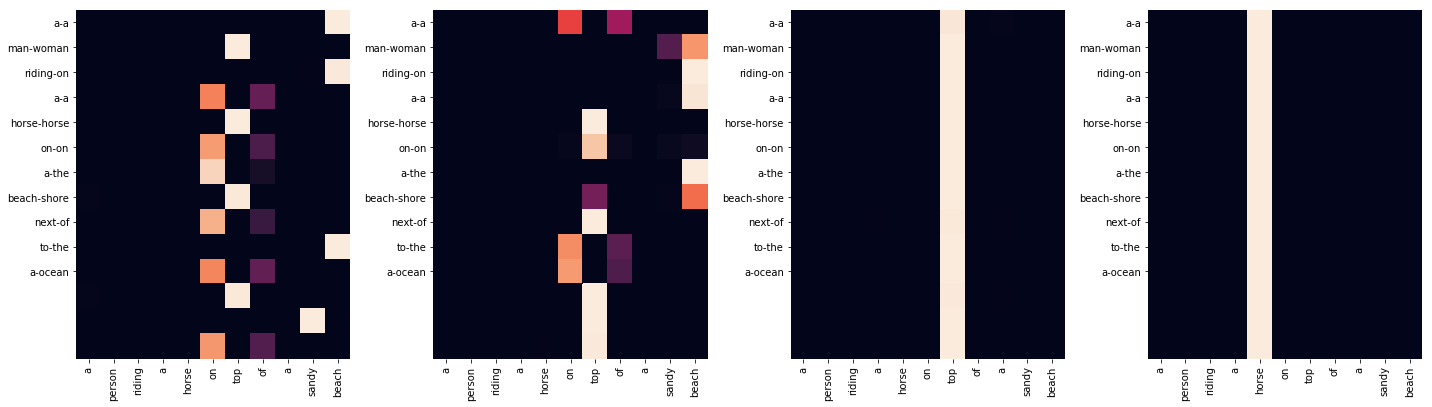

Example 10
SOURCE >> people stand around a bi plane on a runway
PRED   >> a large plane is on the runway at an airport with people watching people are
TARGET >> we see an old picture of people looking at an airplane
[BLEU] 0.0582

Visualizing layer 1


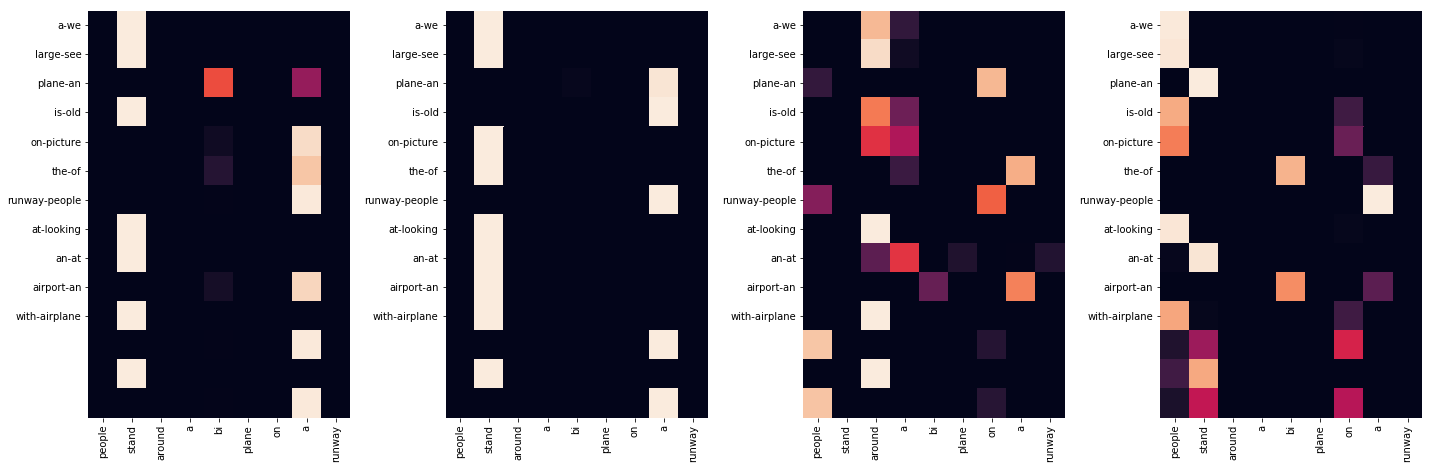

Visualizing layer 2


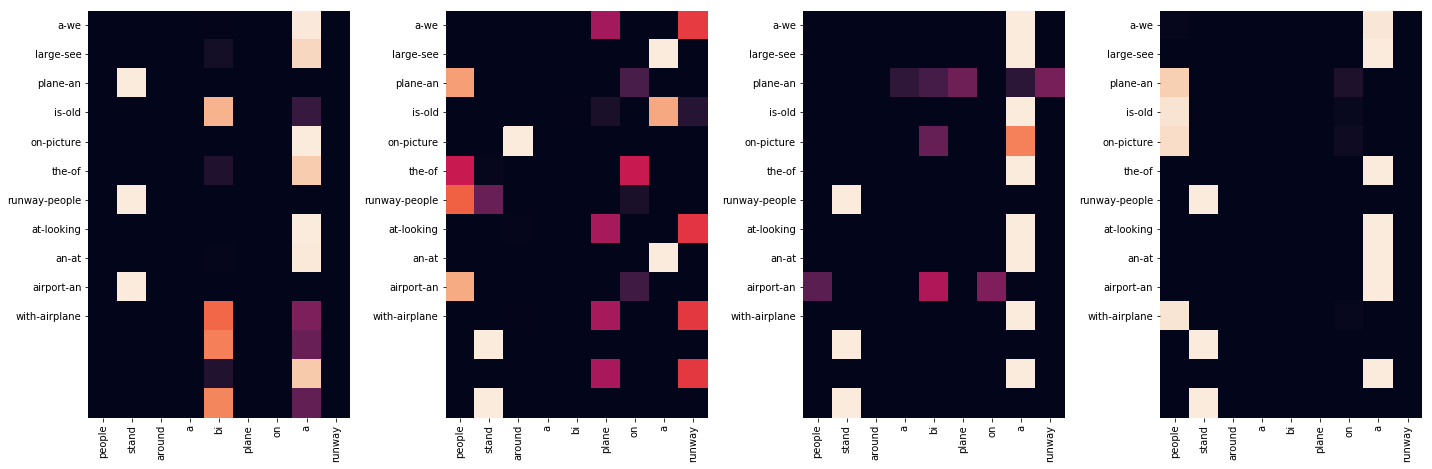

Visualizing layer 3


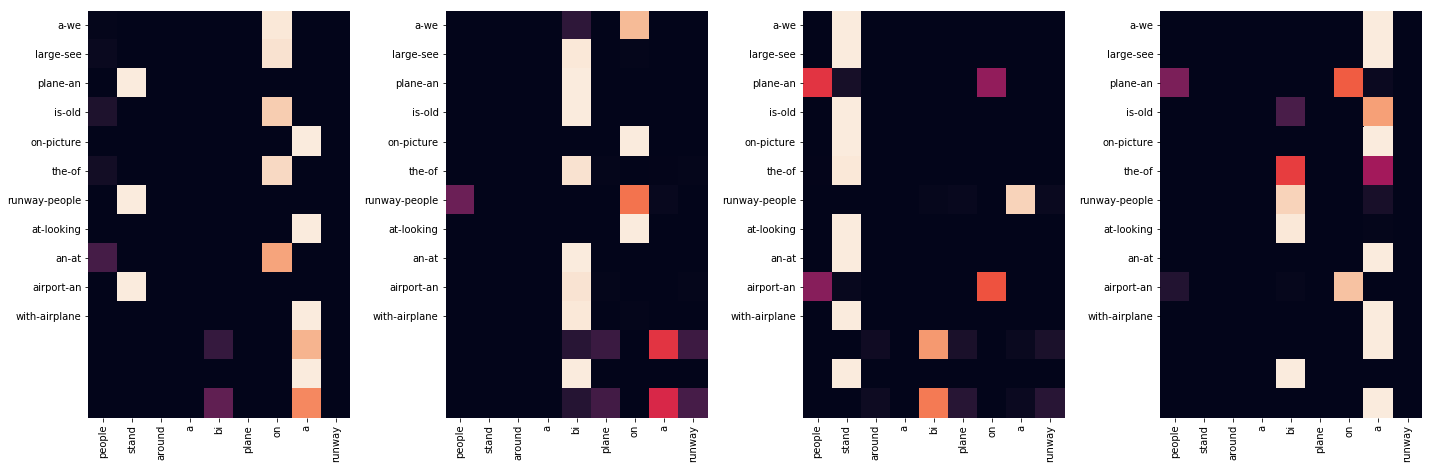

Visualizing layer 4


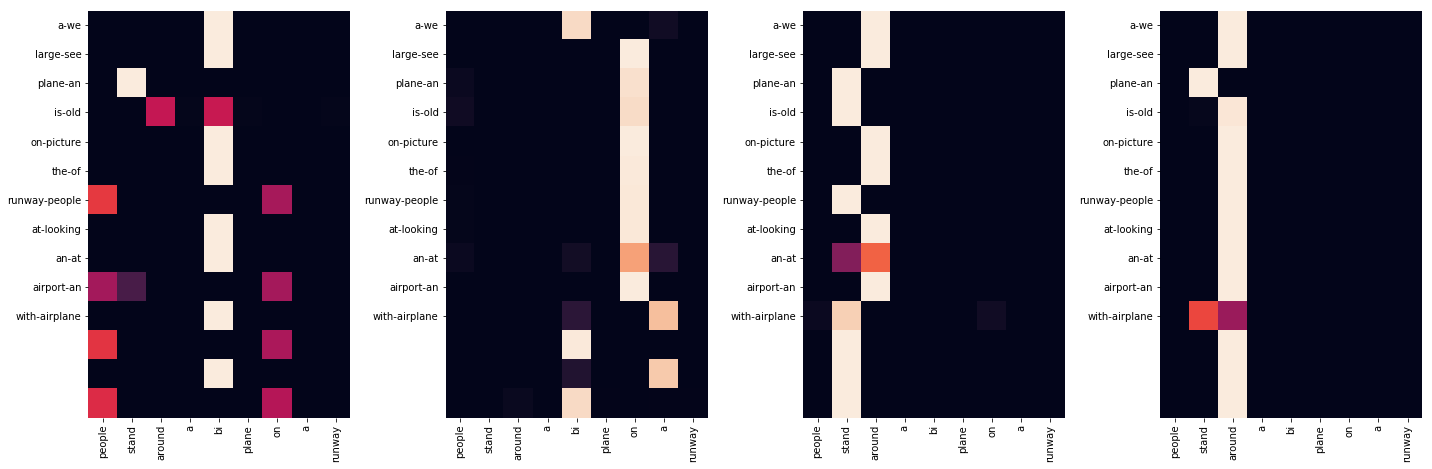

Visualizing layer 5


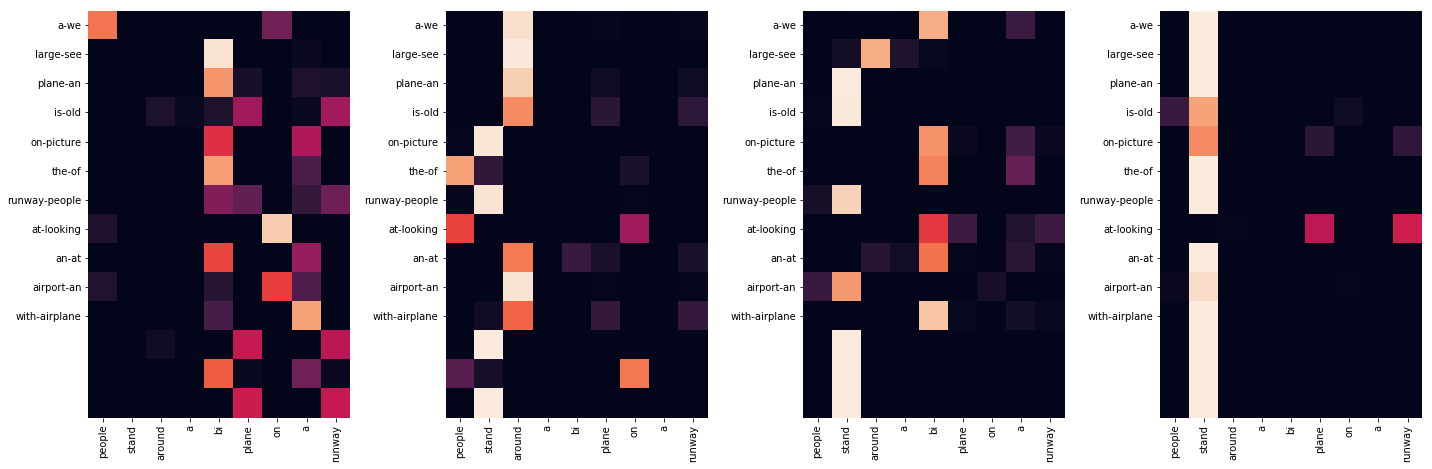

Visualizing layer 6


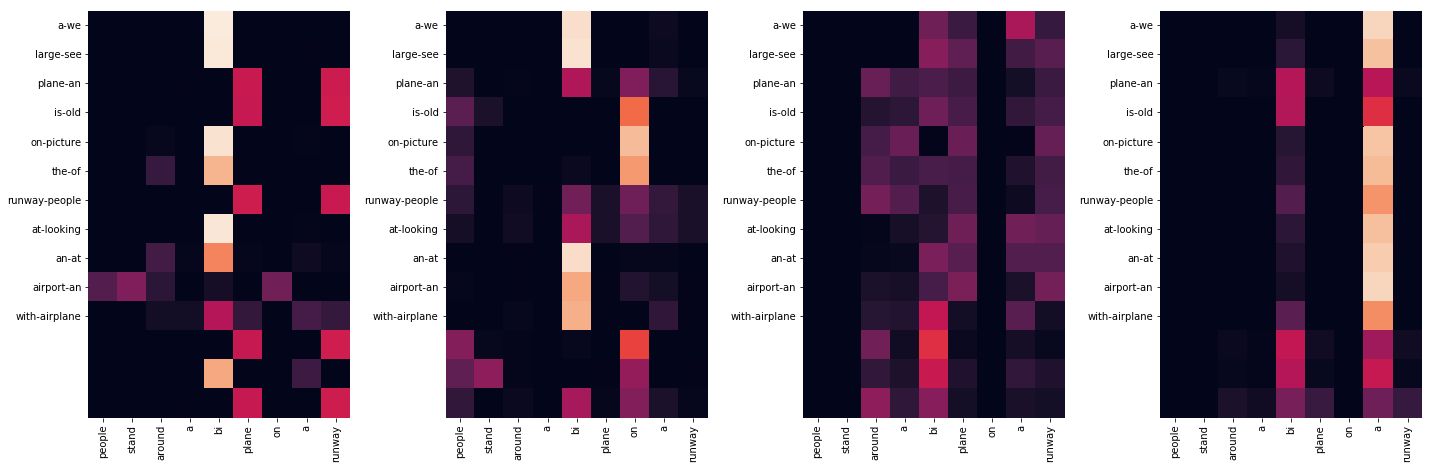

0.07464160563757066

In [54]:
evaluate(model, indexer, test_iter, eval_size=10, smooth_method=SMOOTH.method3) # visualize